In [2]:
import pandas as pd
import numpy as np
import scipy as sp
import datetime as dt
import math

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import learning_curve
from sklearn.model_selection import TimeSeriesSplit, ShuffleSplit, KFold, cross_validate, GridSearchCV, cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn import metrics

import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

## Table of contents
1. [Importing data](#importing)
2. [Base linear regression model](#base)
3. [Cross validation](#cross)
4. [Before/after data models](#before)
5. [Correlated features](#corrfeat)
6. [Interaction terms](#int)
7. [Random forest regression](#forest)
8. [Heat pumps linear regression models](#pumpsmodel)
9. [Modelling only night data](#night)
10. [Investigating individual heat pumps](#indiv)
    1. [Heat pump: 92232.1.0](#pump1)
    2. [Heat pump: 94044.3.0](#pump2)
    3. [Heat pump: 89020.2.0](#pump3)

## Summary

**Fitting basic linear regression models**:

* The regression models were very successful at predicting the chillingPower required from the independent variables. Important variables included the temperature of the fridge, and the number of fridges in a heat pump group. All of the variables had significant p-values, except for "tempAirOut" which is highly correlated with "tempAirIn".
* When the categorical variables indicating which heat pump group a data point belonged to, were removed from the model, the "before_after_seal" attribute  was no longer significant. This suggests that the effect of the door seal depends on the heat pump group: it could have opposite effects for each of the heat pumps.
* The relationship between the other variables and chillinPower is so strong that it dominates the analysis. Therefore it is difficult to extract the much smaller impact of the door seal change.
* The model assumptions are dubious, with questionable normality of residuals, and clear changing variance in the distribution of the residuals.
* The model appears to fit slightly better to the "before" data better than the "after" data. To the strong "split" in the data across these two classes over time, this result is not surprising.

**Cross validation and model assumptions**:
* To test the validity of the linear regression model, cross validation was used.
* Using the time series split cross validation methods ensures that we do not "predict the past from the future", however because the before/after classes are also split over time, this causes huge test score problems when using this method. Therefore instead a "shuffle split" method must be used. 
* The test scores for the model were very high, and there is little variation between them. Thus this algorithm can be assumed to be appropriate for the data.
* Looking at a learning curve, the more observations are added to the dataset, the better the test score becomes.

**Fitting a model to only the "before" and "after" seal data**:
* The only real difference between the two models, that in the model from the before only data, the temperature of the air outlets was insignificant, but the model from the after only data, it becomes significant. However it is unclear how to interpret this, as tempAirOut and tempAirIn strongly correlate.
* The signs of the parameters are consistent across the two models, as are their relative sizes. 
* The fit of the "before" model is slightly better than the "after" model.

**Removing highly correlated attributes from the model**:
* Are the relationships being confused by the large amount of highly correlated variables in the model?
* numOfFridges, measuredTempFridge, setTempFridge, tempAirOut and tempAirIn all correlate extremely strongly. I therefore created a model that included only one of these variables in the analysis.
* The fit of the model does not reduce much, suggesting that for the purpose of predicting chillingPower, these variables are not particularly necessary.

**Interaction terms**:
* I generate all second order interaction terms for the model (except for heat pumps interacting with each other).
* The fit of the model does not improve particularly much, thus the additional interaction terms seem not to contain much more information about chilling power.
* Looking only at the interaction terms that include "before_after_seal", the most important are the interactions of 4 of the heat pump categories with "before_after_seal". 
* Therefore it seems like the different heat pump groups have the largest effect on the way that the seal change influences the chilling power.

**Non-linear terms**:
* If the relationships between the variables are not linear, then it would be necessary to add polynomial terms to the model. However this would make the model extremely complex. Therefore I instead implement a random forest regressor, which can capture non linear relationships.
* The fit of the random forest regression model is very high, with very little variation in the mean test scores.
* Looking at feature importance in the random forest model, the attributes for the number of fridges in the heat pump group, and temperature of the fridges, correspond strongly to chillingPower required.
* The before_after_seal variable is extremely unimportant for predictions.
* Interestingly, in the random forest model, the heat pump categories are also unimportant, whereas in the linear regression model, they were highly important. Does this have to do with the differing assumptions of normality between the two models?

**Impact of heat pumps**:

* It is clear that it may be more useful to look at each heat pump group separately. Although they do not have much impact on the prediction of chillingPower (the fit of the model does not particularly strongly reduce when these attributes are removed), the effects of the different variables on chillingPower and their interactions with each other depends on which heat pump group they are in, thus removing the categorial indicators means these relationships are mixed and obscured in the full data.
* The significance of the heat pump categorical attributes reveal that the variables we have access to don't capture the differences between the heat pumps, because it can't be explained by differences in humidity, outside temperatures, etc.
* This makes it extremely difficult to explain the impact of the door seal change.

**Only looking at night data**
* The effect of customers opening the fridge doors will have a large effect on the fridges - much larger than that of the door seal. Therefore by looking only at data occurring between 1am and 4am, we could assume that no one is opening the doors at this time.  
* For the entire data, the effect isn't changed
* When looking at each of the heat pumps separately, in more cases, the before/after seal variable is no longer significant at night
* When looking at each of the heat pumps separately, the coefficients of all significant terms are negative. This is the opposite effect to that found when examining all of the data, which tended to find a positive coefficient, suggesting that the effect of customers using the fridges obscures the relationship, and in fact the door seal may have had a negative (good) change to chilling power.

**Looking at the different heat pumps separately**:

* Looking at only at the models/heat pumps where "before_after_seal" has a significant p-value, the coefficients for the before_after_seal attribute are positive, suggesting that it has increased the amount of chillingPower required.
* The only models with a negative coeficient are either non significant, or only contain one fridge.
* However the R squared values of these models are relatively low, suggesting that the data does not explain the differences in chillingPower particularly well, and there is a lot of structure in the data not explained by the model.
* Using random forest resulted in better fit, suggesting that the relationship between the variables may not be linear. However before_after_seal is not a feature that is important to the decision tree.

**Looking at a few specific heat pumps**:  
* 92232.1.0: it had the best fitting model, and showed some correlation in the plots. It had positive but small coef for seal.  Multiple fridges in group.
     * For this pump, the correlations between the variables are very low. Plots showed that the different fridges in the heat pump group each had different relationships between the variables, e.g. between temperature of air in and temperature of air out. Thus when they are averaged, this is lost.
     * the coefficient here was positive. The temp air in and out is key. When you add them to model, the p value of before/after seal is almost no longer significant, and the coeficient of the paramete flips. For this heat pump, they do not correlate. This could be because something in the fridge (heat capacity of items inside the fridge is absorbing some of the heat, differently at different times).
* 94044.3.0: it had a negative coef for seal, and only one fridge in its group.  
    * With this heat pump, no matter what, the p value is always significant, and the coefficient is always negative. However the fit of the model is very poor.
* 89020.2.0: it had a positive coef for seal, and only one fridge in its group.
    * For the pumps with just one fridge in the group, the individual relationships are therefore more distinct.
    * Only when temp air in or out is added, then is the p value for the door seal significant. The strength of the differences in air in/out temperature has so much more of an effect on chilling power. that if you don't control for this variable in the model, then before/after seal change can't tell us anything.

**Main conclusion**:
* In general, the seal change seems to have had a negative effect on chilling power, e.g. with the new door seal, the amount of energy required for chilling power has reduced - this is a good change.
* However, the impact of the change to the door seal is very small. The amount of air leaked by one type of door seal compared to another is tiny in scale compared to amount of air let in by someone opening the door, and the impact of other factors (e.g. fridge/evaporator temperatures) on chilling power are massively larger in scale
* Furthermore, the before/after seal feature correlates with time. There are many different factors that can change over time: e.g. the contents of the fridge can be changed over time. Maybe one fridge gets used a lot, maybe another fridge does not, and this can be changed over time. We also do not know about the procedure of changing the door seal - were the fridges also cleaned, or the doors also changed? Therefore we cannot say of certain what has caused the change in the chilling power requirements - it could be the door seal change, or any other change that occurred over time.
* Even if we could extract only the effect of the door seal change, there was no comparison control group: if the previous door seal was degraded/damaged over time, simply a new replacement of the old type of door seal could have shown a similar improvement.
* As a result, the model is not relevant or trustful for the business stakeholders, as we cannot be sure it is actually modelling the factor we want it to, and the effect was small with inconsistent results.

## Importing the data<a name="importing"></a>

In [4]:
fridges = pd.read_csv("data/large_wurm_data.csv", parse_dates=["date"])
fridges = fridges[fridges["before_after_on"]!="on"]
fridges.columns = list(fridges.columns)[:14] + ["before_after_seal"] + list(fridges.columns)[15:]
fridges = fridges.reset_index(drop=True)

In [5]:
data = pd.read_csv("data/model_data.csv", parse_dates=["date"])
data_norm = pd.read_csv("data/model_norm_data.csv", parse_dates=["date"])

In [6]:
pumps = {hp:pd.read_csv("data/heatpumps/" + hp + "_data.csv", parse_dates=["date"]) for hp in list(data_norm.columns[15:].str[9:])}
pumps_norm = {hp:pd.read_csv("data/heatpumps_norm/" + hp + "_norm_data.csv", parse_dates=["date"]) for hp in list(data_norm.columns[15:].str[9:])}

In [7]:
pd.set_option('display.max_columns', 10)

In [8]:
data.head()

,date,marketId,uniqueHpId,numOfFridges,avgMeasuredTempFridge,...,heatPump_91777.3.0,heatPump_92232.1.0,heatPump_93593.2.0,heatPump_94044.2.0,heatPump_94044.3.0
0,2021-12-29 00:00:00+00:00,89020,89020.1.0,12,6.229,...,0.000,0.000,0.000,0.000,0.000
1,2021-12-29 01:00:00+00:00,89020,89020.1.0,12,5.875,...,0.000,0.000,0.000,0.000,0.000
2,2021-12-29 02:00:00+00:00,89020,89020.1.0,12,6.083,...,0.000,0.000,0.000,0.000,0.000
3,2021-12-29 03:00:00+00:00,89020,89020.1.0,12,6.083,...,0.000,0.000,0.000,0.000,0.000
4,2021-12-29 04:00:00+00:00,89020,89020.1.0,12,5.979,...,0.000,0.000,0.000,0.000,0.000


In [9]:
data_norm.head()

,date,marketId,uniqueHpId,numOfFridges,avgMeasuredTempFridge,...,heatPump_91777.3.0,heatPump_92232.1.0,heatPump_93593.2.0,heatPump_94044.2.0,heatPump_94044.3.0
0,2021-12-29 00:00:00+00:00,89020,89020.1.0,0.840,0.917,...,0.000,0.000,0.000,0.000,0.000
1,2021-12-29 01:00:00+00:00,89020,89020.1.0,0.840,0.765,...,0.000,0.000,0.000,0.000,0.000
2,2021-12-29 02:00:00+00:00,89020,89020.1.0,0.840,0.855,...,0.000,0.000,0.000,0.000,0.000
3,2021-12-29 03:00:00+00:00,89020,89020.1.0,0.840,0.855,...,0.000,0.000,0.000,0.000,0.000
4,2021-12-29 04:00:00+00:00,89020,89020.1.0,0.840,0.810,...,0.000,0.000,0.000,0.000,0.000


In [330]:
pumps['89020.1.0'].head()

,date,marketId,uniqueHpId,numOfFridges,avgMeasuredTempFridge,...,outsideTempHeatPump,marketTemp,humidity,before_after_seal,chillingPower
0,2021-12-29 00:00:00+00:00,89020,89020.1.0,12,6.229,...,3.800,14.875,49.000,0,4.625
1,2021-12-29 01:00:00+00:00,89020,89020.1.0,12,5.875,...,4.450,14.750,49.000,0,5.500
2,2021-12-29 02:00:00+00:00,89020,89020.1.0,12,6.083,...,5.250,14.825,48.000,0,4.500
3,2021-12-29 03:00:00+00:00,89020,89020.1.0,12,6.083,...,5.850,14.850,48.000,0,5.000
4,2021-12-29 04:00:00+00:00,89020,89020.1.0,12,5.979,...,5.700,14.850,48.000,0,3.625


In [331]:
pumps_norm['89020.1.0'].head()

,date,marketId,uniqueHpId,numOfFridges,avgMeasuredTempFridge,...,outsideTempHeatPump,marketTemp,humidity,before_after_seal,chillingPower
0,2021-12-29 00:00:00+00:00,89020,89020.1.0,0.000,2.502,...,-0.682,-0.252,-0.159,0,-0.898
1,2021-12-29 01:00:00+00:00,89020,89020.1.0,0.000,-1.706,...,-0.462,-0.437,-0.159,0,-0.056
2,2021-12-29 02:00:00+00:00,89020,89020.1.0,0.000,0.769,...,-0.190,-0.326,-0.429,0,-1.018
3,2021-12-29 03:00:00+00:00,89020,89020.1.0,0.000,0.769,...,0.013,-0.289,-0.429,0,-0.537
4,2021-12-29 04:00:00+00:00,89020,89020.1.0,0.000,-0.468,...,-0.038,-0.289,-0.429,0,-1.859


Indicating which attributes are the x variables, and which is the target variable:

In [11]:
X_vars = ['before_after_seal', 'numOfFridges', 'avgMeasuredTempFridge', 'avgSetTempFridge', 'avgTempAirOut', 'avgTempAirIn', 'avgMeasuredTempEvap', 'avgSetTempEvap', 'outsideTempHeatPump', 
          'marketTemp', 'humidity', 'heatPump_89020.1.0', 'heatPump_89020.2.0', 'heatPump_91728.2.0', 'heatPump_91777.3.0', 'heatPump_92232.1.0',
          'heatPump_93593.2.0', 'heatPump_94044.2.0', 'heatPump_94044.3.0']
X_vars_pump = X_vars[:11]
y_var = 'chillingPower'

## Base linear regression model<a name="base"></a>

Creating a basic linear model:

In [333]:
stats_model = sm.OLS(data[y_var], sm.add_constant(data_norm[X_vars])).fit()
stats_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          chillingPower   R-squared:                       0.953
Model:                            OLS   Adj. R-squared:                  0.953
Method:                 Least Squares   F-statistic:                 1.357e+04
Date:                Thu, 26 Jan 2023   Prob (F-statistic):               0.00
Time:                        10:45:55   Log-Likelihood:                -20705.
No. Observations:               10688   AIC:                         4.144e+04
Df Residuals:                   10671   BIC:                         4.157e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    10.4389      0.022    476.433      0.000      10.396      10.482
before_after_seal        -0.3523      0.037     -9.443      0.000      -0.425      -0.279
numOfFridges              3.6248      0.040     91.530      0.000       3.547       3.702
avgMeasuredTempFridge     4.9209      0.420     11.719      0.000       4.098       5.744
avgSetTempFridge          1.7246      0.054     32.120      0.000       1.619       1.830
avgTempAirOut            -0.2343      0.272     -0.860      0.390      -0.768       0.300
avgTempAirIn             -4.4450      0.196    -22.671      0.000      -4.829      -4.061
avgMeasuredTempEvap       1.8901      0.051     36.871      0.000       1.790       1.991
avgSetTempEvap           -1.8842      0.068    -27.719      0.000      -2.017      -1.751
outsideTempHeatPump       0.3457      0.025     13.995      0.000       0.297       0.394
marketTemp                1.5895      0.047     33.696      0.000       1.497       1.682
humidity                  0.2111      0.042      5.043      0.000       0.129       0.293
heatPump_89020.1.0       -6.4994      0.123    -52.936      0.000      -6.740      -6.259
heatPump_89020.2.0        2.7280      0.091     29.985      0.000       2.550       2.906
heatPump_91728.2.0        4.2601      0.082     52.181      0.000       4.100       4.420
heatPump_91777.3.0       -1.0809      0.109     -9.876      0.000      -1.295      -0.866
heatPump_92232.1.0        1.2825      0.092     13.869      0.000       1.101       1.464
heatPump_93593.2.0        7.2191      0.087     82.595      0.000       7.048       7.390
heatPump_94044.2.0        1.8082      0.080     22.546      0.000       1.651       1.965
heatPump_94044.3.0        0.7212      0.051     14.178      0.000       0.621       0.821
==============================================================================
Omnibus:                      676.335   Durbin-Watson:                   0.963
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1929.142
Skew:                           0.332   Prob(JB):                         0.00
Kurtosis:                       4.972   Cond. No.                     1.09e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.98e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [334]:
stats_model = sm.OLS(data_norm[y_var], sm.add_constant(data_norm[X_vars])).fit()
stats_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          chillingPower   R-squared:                       0.953
Model:                            OLS   Adj. R-squared:                  0.953
Method:                 Least Squares   F-statistic:                 1.357e+04
Date:                Thu, 26 Jan 2023   Prob (F-statistic):               0.00
Time:                        10:45:55   Log-Likelihood:                 1191.4
No. Observations:               10688   AIC:                            -2349.
Df Residuals:                   10671   BIC:                            -2225.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.0208      0.003      7.381      0.000       0.015       0.026
before_after_seal        -0.0454      0.005     -9.443      0.000      -0.055      -0.036
numOfFridges              0.4671      0.005     91.493      0.000       0.457       0.477
avgMeasuredTempFridge     0.6343      0.054     11.719      0.000       0.528       0.740
avgSetTempFridge          0.2230      0.007     32.222      0.000       0.209       0.237
avgTempAirOut            -0.0302      0.035     -0.860      0.390      -0.099       0.039
avgTempAirIn             -0.5730      0.025    -22.671      0.000      -0.623      -0.523
avgMeasuredTempEvap       0.2436      0.007     36.871      0.000       0.231       0.257
avgSetTempEvap           -0.2429      0.009    -27.719      0.000      -0.260      -0.226
outsideTempHeatPump       0.0446      0.003     13.995      0.000       0.038       0.051
marketTemp                0.2049      0.006     33.696      0.000       0.193       0.217
humidity                  0.0272      0.005      5.043      0.000       0.017       0.038
heatPump_89020.1.0       -1.0038      0.016    -63.427      0.000      -1.035      -0.973
heatPump_89020.2.0        0.1867      0.012     15.921      0.000       0.164       0.210
heatPump_91728.2.0        0.3832      0.011     36.414      0.000       0.363       0.404
heatPump_91777.3.0       -0.3043      0.014    -21.568      0.000      -0.332      -0.277
heatPump_92232.1.0       -0.0007      0.012     -0.058      0.954      -0.024       0.023
heatPump_93593.2.0        0.7647      0.011     67.872      0.000       0.743       0.787
heatPump_94044.2.0        0.0670      0.010      6.479      0.000       0.047       0.087
heatPump_94044.3.0       -0.0720      0.007    -10.976      0.000      -0.085      -0.059
==============================================================================
Omnibus:                      676.335   Durbin-Watson:                   0.963
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1929.142
Skew:                           0.332   Prob(JB):                         0.00
Kurtosis:                       4.972   Cond. No.                     1.09e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.98e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Text(0, 0.5, 'Normalised Coefficient')

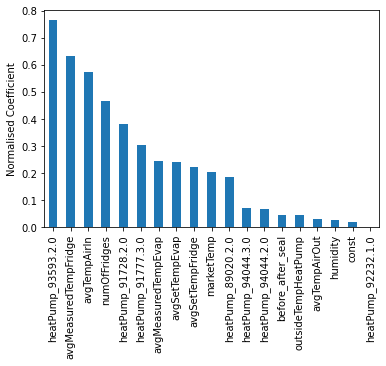

In [335]:
ax=stats_model.params.abs().sort_values(ascending=False)[1:].plot.bar()
ax.set_ylabel("Normalised Coefficient")

In [336]:
stats_model = sm.OLS(data[y_var], sm.add_constant(data[X_vars])).fit()
stats_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          chillingPower   R-squared:                       0.953
Model:                            OLS   Adj. R-squared:                  0.953
Method:                 Least Squares   F-statistic:                 1.357e+04
Date:                Thu, 26 Jan 2023   Prob (F-statistic):               0.00
Time:                        10:45:55   Log-Likelihood:                -20705.
No. Observations:               10688   AIC:                         4.144e+04
Df Residuals:                   10671   BIC:                         4.157e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -8.3074      0.342    -24.304      0.000      -8.977      -7.637
before_after_seal        -0.3523      0.037     -9.443      0.000      -0.425      -0.279
numOfFridges              2.1380      0.019    114.295      0.000       2.101       2.175
avgMeasuredTempFridge     2.1139      0.180     11.719      0.000       1.760       2.467
avgSetTempFridge         -3.0055      0.070    -42.711      0.000      -3.143      -2.868
avgTempAirOut            -0.1000      0.116     -0.860      0.390      -0.328       0.128
avgTempAirIn             -1.8956      0.084    -22.671      0.000      -2.059      -1.732
avgMeasuredTempEvap       0.6770      0.018     36.871      0.000       0.641       0.713
avgSetTempEvap           -0.8967      0.032    -27.719      0.000      -0.960      -0.833
outsideTempHeatPump       0.0957      0.007     13.995      0.000       0.082       0.109
marketTemp                0.6988      0.021     33.696      0.000       0.658       0.739
humidity                  0.0280      0.006      5.043      0.000       0.017       0.039
heatPump_89020.1.0       -7.6875      0.132    -58.445      0.000      -7.945      -7.430
heatPump_89020.2.0       -1.3488      0.149     -9.026      0.000      -1.642      -1.056
heatPump_91728.2.0        2.8094      0.080     34.927      0.000       2.652       2.967
heatPump_91777.3.0       -5.1576      0.184    -28.065      0.000      -5.518      -4.797
heatPump_92232.1.0       -0.2176      0.090     -2.413      0.016      -0.394      -0.041
heatPump_93593.2.0        3.1517      0.092     34.148      0.000       2.971       3.333
heatPump_94044.2.0        3.4987      0.098     35.595      0.000       3.306       3.691
heatPump_94044.3.0       -3.3556      0.131    -25.595      0.000      -3.613      -3.099
==============================================================================
Omnibus:                      676.335   Durbin-Watson:                   0.963
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1929.142
Skew:                           0.332   Prob(JB):                         0.00
Kurtosis:                       4.972   Cond. No.                     5.47e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 9.2e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

---
The p value of the before/after seal is significant, however the coefficient is very small at -0.3523.  
Removing the attributes indicating the heat pump groups:

In [337]:
stats_model = sm.OLS(data[y_var], sm.add_constant(data_norm[X_vars[:11]])).fit()
stats_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          chillingPower   R-squared:                       0.918
Model:                            OLS   Adj. R-squared:                  0.918
Method:                 Least Squares   F-statistic:                 1.089e+04
Date:                Thu, 26 Jan 2023   Prob (F-statistic):               0.00
Time:                        10:45:55   Log-Likelihood:                -23685.
No. Observations:               10688   AIC:                         4.739e+04
Df Residuals:                   10676   BIC:                         4.748e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    11.5954      0.031    368.977      0.000      11.534      11.657
before_after_seal        -0.0674      0.046     -1.466      0.143      -0.158       0.023
numOfFridges              1.8431      0.139     13.298      0.000       1.571       2.115
avgMeasuredTempFridge    25.9814      0.307     84.760      0.000      25.381      26.582
avgSetTempFridge          4.1737      0.173     24.174      0.000       3.835       4.512
avgTempAirOut           -11.1037      0.214    -51.897      0.000     -11.523     -10.684
avgTempAirIn            -14.3729      0.141   -102.221      0.000     -14.648     -14.097
avgMeasuredTempEvap       1.4934      0.041     36.598      0.000       1.413       1.573
avgSetTempEvap           -4.6304      0.055    -83.743      0.000      -4.739      -4.522
outsideTempHeatPump      -0.0841      0.029     -2.888      0.004      -0.141      -0.027
marketTemp                2.3492      0.045     52.504      0.000       2.262       2.437
humidity                  1.1684      0.044     26.289      0.000       1.081       1.256
==============================================================================
Omnibus:                      274.816   Durbin-Watson:                   1.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              364.947
Skew:                           0.306   Prob(JB):                     5.66e-80
Kurtosis:                       3.667   Cond. No.                         40.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [338]:
stats_model.params.abs().sort_values(ascending=False)

avgMeasuredTempFridge   25.981
avgTempAirIn            14.373
const                   11.595
avgTempAirOut           11.104
avgSetTempEvap           4.630
avgSetTempFridge         4.174
marketTemp               2.349
numOfFridges             1.843
avgMeasuredTempEvap      1.493
humidity                 1.168
outsideTempHeatPump      0.084
before_after_seal        0.067
dtype: float64

In [339]:
stats_model = sm.OLS(data[y_var], sm.add_constant(data[X_vars[:11]])).fit()
stats_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          chillingPower   R-squared:                       0.918
Model:                            OLS   Adj. R-squared:                  0.918
Method:                 Least Squares   F-statistic:                 1.089e+04
Date:                Thu, 26 Jan 2023   Prob (F-statistic):               0.00
Time:                        10:45:55   Log-Likelihood:                -23685.
No. Observations:               10688   AIC:                         4.739e+04
Df Residuals:                   10676   BIC:                         4.748e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   -34.3269      0.475    -72.246      0.000     -35.258     -33.396
before_after_seal        -0.0674      0.046     -1.466      0.143      -0.158       0.023
numOfFridges              0.3553      0.027     13.298      0.000       0.303       0.408
avgMeasuredTempFridge    11.1610      0.132     84.760      0.000      10.903      11.419
avgSetTempFridge          1.7877      0.074     24.174      0.000       1.643       1.933
avgTempAirOut            -4.7384      0.091    -51.897      0.000      -4.917      -4.559
avgTempAirIn             -6.1293      0.060   -102.221      0.000      -6.247      -6.012
avgMeasuredTempEvap       0.5349      0.015     36.598      0.000       0.506       0.564
avgSetTempEvap           -2.2037      0.026    -83.743      0.000      -2.255      -2.152
outsideTempHeatPump      -0.0233      0.008     -2.888      0.004      -0.039      -0.007
marketTemp                1.0328      0.020     52.504      0.000       0.994       1.071
humidity                  0.1548      0.006     26.289      0.000       0.143       0.166
==============================================================================
Omnibus:                      274.816   Durbin-Watson:                   1.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              364.947
Skew:                           0.306   Prob(JB):                     5.66e-80
Kurtosis:                       3.667   Cond. No.                     1.12e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.12e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

---
When the attributes indicating the heat pump group is removed, the before/after seal variable is no longer significant, p value 0.143 .  

This could suggest that for different heat pumps, the door seal change has opposite effects - which therefore cancel out when looking at every heat pump at once.

Therefore it may be more useful to look at each heat pump group separately. Although they do not have much impact on the prediction of chillingPower (the fit of the model does not particularly strongly reduce), it is clear that the effects of the different variables on chillingPower depends on which heat pump group they are in, thus removing the categorial indicators means these relationships are mixed and obscured in the full data.

## Cross validation and assumption checking on the base model<a name="cross"></a>

Using the time series split cross validation methods ensures that we do not "predict the past from the future", however because the before/after classes are also split over time, this causes huge test score problems when using this method.

In [340]:
tscv_results = pd.DataFrame(cross_validate(LinearRegression(), data[X_vars].values, data[y_var].values, 
                                           cv=TimeSeriesSplit(n_splits=10), scoring="r2", return_train_score=True))
tscv_results

,fit_time,score_time,test_score,train_score
0,0.003,0.000,-1.684,0.666
1,0.001,0.000,-1062220575657792765952.000,0.613
2,0.002,0.000,0.285,0.940
3,0.002,0.000,-810387041004812809273344.000,0.945
4,0.002,0.000,-1909547776291994.250,0.938
5,0.002,0.000,-2038363359185642752.000,0.940
6,0.002,0.000,0.058,0.945
7,0.003,0.000,-195070082838823584.000,0.954
8,0.003,0.000,-31946607811732.051,0.952
9,0.003,0.000,-0.845,0.950


In [341]:
kfcv_results = pd.DataFrame(cross_validate(LinearRegression(), data[X_vars].values, data[y_var].values, 
                                           cv=ShuffleSplit(n_splits=10, random_state=0), scoring="r2", return_train_score=True))
kfcv_results

,fit_time,score_time,test_score,train_score
0,0.004,0.000,0.951,0.953
1,0.003,0.000,0.949,0.954
2,0.003,0.000,0.954,0.953
3,0.004,0.000,0.950,0.954
4,0.004,0.000,0.952,0.953
5,0.004,0.000,0.954,0.953
6,0.003,0.000,0.953,0.953
7,0.003,0.000,0.954,0.953
8,0.004,0.000,0.952,0.953
9,0.003,0.000,0.952,0.953


Using a "shuffle" (i.e. randomisation method) for cross validation improves the test scores dramatically, and there is very little variation between them. It is clear that going forward, this will be the method required to evaluate the models.

The more observations are added to the dataset, the better the test score becomes.

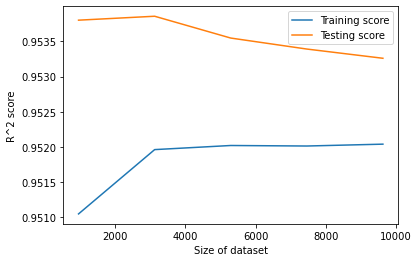

In [342]:
size, test, train = learning_curve(LinearRegression(),data[X_vars].values, data[y_var].values, 
               train_sizes=np.linspace(0.1, 1.0, num=5, endpoint=True), 
               cv=ShuffleSplit(n_splits=10, random_state=0), scoring="r2")

plt.plot(size, train.mean(axis=1), label="Training score")
plt.plot(size, test.mean(axis=1), label="Testing score")
plt.legend();
plt.ylabel("R^2 score")
plt.xlabel("Size of dataset");

Checking the assumptions of the model using residual plots:

In [343]:
def residual_plots(model):
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 7))
    fig.subplots_adjust(wspace=0.25, hspace=0.25)
    fig.suptitle("Diagnostic Plots", fontsize=15)

    axes[0][0].hist(pd.Series(model.resid_pearson), bins=15, edgecolor="white", color="dodgerblue")
    sp.stats.probplot(pd.Series(model.resid_pearson), plot=axes[0][1], fit=True)
    axes[0][2].scatter(pd.DataFrame(model.resid_pearson).merge(pd.DataFrame(model.fittedvalues), 
                                                    left_index=True, right_index=True)["0_y"],
                       pd.DataFrame(model.resid_pearson).merge(pd.DataFrame(model.fittedvalues), 
                                                    left_index=True, right_index=True)["0_x"], 
                       alpha=0.7, s=10, color="dodgerblue")
    axes[0][2].axhline(y=0, color="red", linestyle="-")
    axes[1][0].scatter(list(pd.Series(model.get_influence().hat_matrix_diag).index),
                       pd.Series(model.get_influence().hat_matrix_diag), alpha=0.7, s=10, color="dodgerblue")
    axes[1][1].scatter(list(pd.Series(model.get_influence().cooks_distance[0]).index),
                       pd.Series(model.get_influence().cooks_distance[0]), alpha=0.7, s=10, color="dodgerblue")
    axes[1][2].scatter(abs(pd.DataFrame(model.resid_pearson).merge(pd.DataFrame(model.fittedvalues), 
                                                    left_index=True, right_index=True)["0_x"]),
                       pd.Series(model.get_influence().hat_matrix_diag), alpha=0.7, s=10, color="dodgerblue")

    axes[0][0].set_title("Residuals", fontsize=13)
    axes[0][0].text(0.55, 0.8, "Skew: {0:.2f}".format(pd.Series(model.resid_pearson).skew()), 
                    fontsize=12, horizontalalignment="left", transform=axes[0][0].transAxes,  
                     bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
    axes[0][1].set_xlabel(""), axes[0][1].set_ylabel(""), axes[0][1].set_title("Normal Plot", fontsize=13)
    axes[0][1].get_lines()[0].set_markerfacecolor("dodgerblue")
    axes[0][1].get_lines()[0].set_markersize(5)
    axes[0][1].get_lines()[0].set_markeredgecolor("None")
    axes[0][2].set_title("Fitted Values", fontsize=13), axes[0][2].set_ylabel("Standardised Residuals", fontsize=13, rotation=-90, labelpad=20)
    axes[1][0].set_title("Leverage", fontsize=13)
    axes[1][1].set_title("Cook's Distance", fontsize=13)
    axes[1][2].set_title("Residuals vs Leverage", fontsize=13);
    axes[1][2].set_xlabel("(Absolute) Standardised Residuals", fontsize=13), axes[1][2].set_ylabel("Leverage", fontsize=13, rotation=-90, labelpad=20),
    axes[1][2].yaxis.set_label_position("right"), axes[0][2].yaxis.set_label_position("right")
    axes[1][0].set_xlabel("Index", fontsize=13), axes[1][1].set_xlabel("Index", fontsize=13)

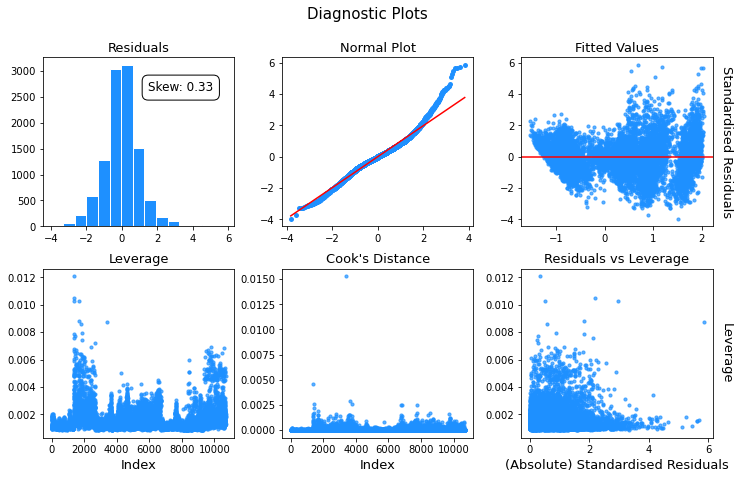

In [345]:
residual_plots(sm.OLS(data_norm[y_var], sm.add_constant(data_norm[X_vars])).fit())

The normal plot indicates that normallity is questionable, and the fitted values do not seem to have constant variance. This is likely due to the strong connection between the distribution of the classes over time. The model perhaps fits the "before" data better than the "after" data.

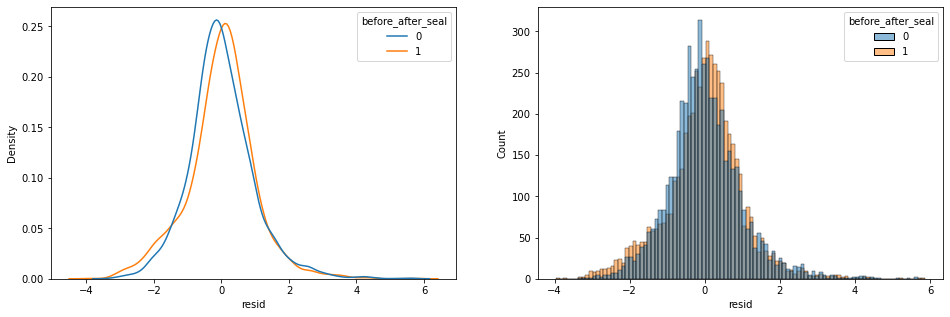

In [346]:
model = sm.OLS(data[y_var], sm.add_constant(data[X_vars])).fit()
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16,5))
sns.kdeplot(data=pd.concat([pd.DataFrame(model.resid_pearson, columns=["resid"]), data["before_after_seal"]], axis=1), 
            x="resid", hue="before_after_seal", multiple="layer", ax=ax1)
sns.histplot(data=pd.concat([pd.DataFrame(model.resid_pearson, columns=["resid"]), data["before_after_seal"]], axis=1), 
            x="resid", hue="before_after_seal", multiple="layer", ax=ax2);

The residuals for the "after" data are slightly larger than for the "before" data.

Perhaps a model would fit better to the two "before" and "after" datasets separately.

## Comparing models fitted only on "before" or "after" data<a name="before"></a>

Comparing the feature coefficients, for models fitted only on the "before" and "after" seal change data respectively:

In [347]:
before_model = sm.OLS(data[data["before_after_seal"]==0][y_var], sm.add_constant(data[data["before_after_seal"]==0][X_vars[1:]])).fit()
after_model = sm.OLS(data[data["before_after_seal"]==1][y_var], sm.add_constant(data[data["before_after_seal"]==1][X_vars[1:]])).fit()
before_model_no_hp = sm.OLS(data[data["before_after_seal"]==0][y_var], sm.add_constant(data[data["before_after_seal"]==0][X_vars[1:11]])).fit()
after_model_no_hp = sm.OLS(data[data["before_after_seal"]==1][y_var], sm.add_constant(data[data["before_after_seal"]==1][X_vars[1:11]])).fit()

In [348]:
compare_ba = pd.concat([before_model.pvalues, after_model.pvalues, before_model_no_hp.pvalues, after_model_no_hp.pvalues, 
           before_model.params, after_model.params, before_model_no_hp.params, after_model_no_hp.params], axis=1)
compare_ba.columns=["before_p", "after_p", "before_no_hp_p", "after_no_hp_p", "before_params", "after_params", "before_no_hp_params", "after_no_hp_params"]
compare_ba

,before_p,after_p,before_no_hp_p,after_no_hp_p,before_params,after_params,before_no_hp_params,after_no_hp_params
const,0.000,0.000,0.000,0.000,-7.752,-9.245,-41.127,-31.607
numOfFridges,0.000,0.000,0.000,0.000,2.177,2.071,0.181,0.442
avgMeasuredTempFridge,0.000,0.000,0.000,0.000,2.050,1.904,11.315,10.761
avgSetTempFridge,0.000,0.000,0.000,0.000,-3.026,-3.343,2.231,1.349
avgTempAirOut,0.734,0.000,0.000,0.000,0.054,1.107,-5.237,-3.477
avgTempAirIn,0.000,0.000,0.000,0.000,-1.976,-2.631,-5.837,-6.806
avgMeasuredTempEvap,0.000,0.000,0.000,0.000,0.696,0.618,0.552,0.576
avgSetTempEvap,0.000,0.000,0.000,0.000,-0.775,-0.891,-2.177,-2.269
outsideTempHeatPump,0.000,0.000,0.000,0.018,0.093,0.083,-0.137,0.024
marketTemp,0.000,0.000,0.000,0.000,0.672,0.632,1.281,0.897


In [349]:
print("rsquared fit of models:", "\nbefore model:", before_model.rsquared, "\nafter model:", after_model.rsquared, "\nbefore model no hp:", before_model_no_hp.rsquared, "\nafter model no hp:", after_model_no_hp.rsquared)

rsquared fit of models: 
before model: 0.9614308554756595 
after model: 0.9498868946351436 
before model no hp: 0.9254234781342855 
after model no hp: 0.9186721797551975


The only real change is that in the before only data, the temperature of the air outlets was insignificant, but afterwards it comes significant. However it is unclear how to interpret this, as tempAirOut and tempAirIn strongly correlate.

The model fits to the "before" data slightly better than the "after" data, as suggested at previously. The fit of the model is clearly improved by including the heat pump categories.

In [350]:
before_model = sm.OLS(data[data["before_after_seal"]==0][y_var], sm.add_constant(data_norm[data_norm["before_after_seal"]==0][X_vars[1:]])).fit()
after_model = sm.OLS(data[data["before_after_seal"]==1][y_var], sm.add_constant(data_norm[data_norm["before_after_seal"]==1][X_vars[1:]])).fit()
before_model_no_hp = sm.OLS(data[data["before_after_seal"]==0][y_var], sm.add_constant(data_norm[data_norm["before_after_seal"]==0][X_vars[1:11]])).fit()
after_model_no_hp = sm.OLS(data[data["before_after_seal"]==1][y_var], sm.add_constant(data_norm[data_norm["before_after_seal"]==1][X_vars[1:11]])).fit()

In [351]:
compare_ba = pd.concat([before_model.pvalues, after_model.pvalues, before_model_no_hp.pvalues, after_model_no_hp.pvalues, 
           before_model.params, after_model.params, before_model_no_hp.params, after_model_no_hp.params], axis=1)
compare_ba.columns=["before_p", "after_p", "before_no_hp_p", "after_no_hp_p", "before_params", "after_params", "before_no_hp_params", "after_no_hp_params"]
compare_ba

,before_p,after_p,before_no_hp_p,after_no_hp_p,before_params,after_params,before_no_hp_params,after_no_hp_params
const,0.000,0.000,0.000,0.000,10.415,10.300,11.649,11.712
numOfFridges,0.000,0.000,0.000,0.000,3.728,3.158,0.939,2.293
avgMeasuredTempFridge,0.000,0.000,0.000,0.000,4.772,4.433,26.339,25.050
avgSetTempFridge,0.000,0.000,0.000,0.000,1.662,1.293,5.209,3.150
avgTempAirOut,0.734,0.000,0.000,0.000,0.127,2.593,-12.272,-8.147
avgTempAirIn,0.000,0.000,0.000,0.000,-4.634,-6.169,-13.687,-15.960
avgMeasuredTempEvap,0.000,0.000,0.000,0.000,1.944,1.724,1.540,1.608
avgSetTempEvap,0.000,0.000,0.000,0.000,-1.628,-1.872,-4.574,-4.769
outsideTempHeatPump,0.000,0.000,0.000,0.018,0.337,0.301,-0.494,0.085
marketTemp,0.000,0.000,0.000,0.000,1.528,1.439,2.915,2.040


In [352]:
print("rsquared fit of models:", "\nbefore model:", before_model.rsquared, "\nafter model:", after_model.rsquared, "\nbefore model no hp:", before_model_no_hp.rsquared, "\nafter model no hp:", after_model_no_hp.rsquared)

rsquared fit of models: 
before model: 0.9614308554756595 
after model: 0.9498868946351436 
before model no hp: 0.9254234781342855 
after model no hp: 0.9186721797551977


## Removing correlated variables from the model<a name="corrfeat"></a>

Is the relationship also being confused by the large amount of highly correlated variables?

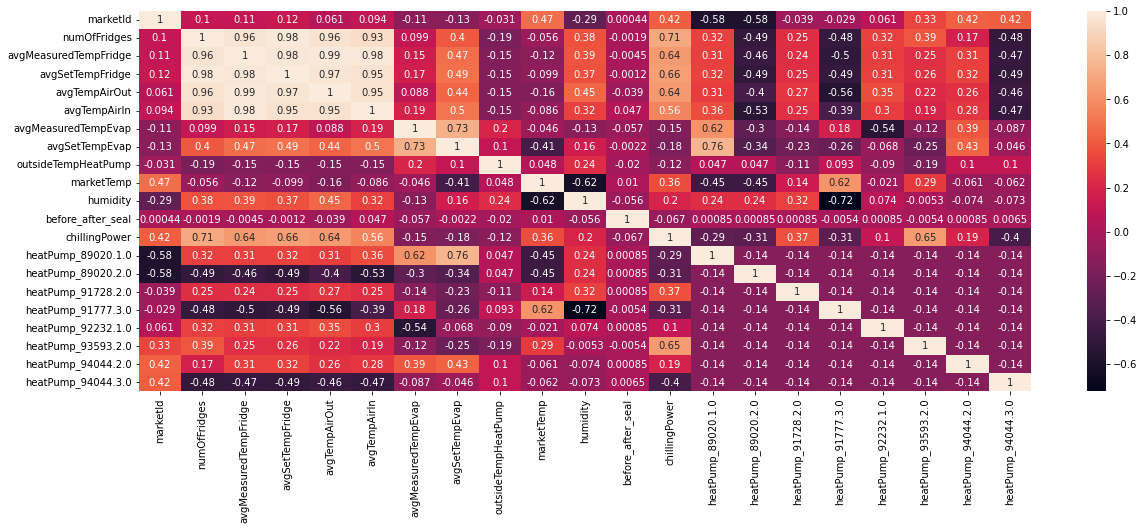

In [355]:
plt.figure(figsize=(20, 7))
sns.heatmap(data.corr(), annot=True);

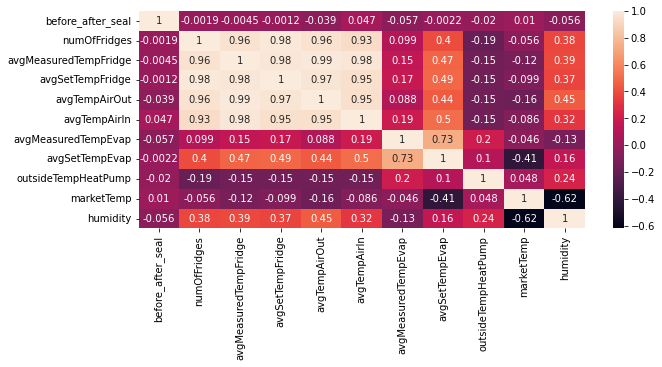

In [353]:
plt.figure(figsize=(10, 4))
sns.heatmap(data[X_vars[:11]].corr(), annot=True);

numOfFridges, measuredTempFridge, setTempFridge, tempAirOut and tempAirIn all correlate extremely strongly. I will create a model that only includes one of these variables in the analysis.

In [356]:
stats_model = sm.OLS(data[y_var], sm.add_constant(data[["before_after_seal", "avgMeasuredTempFridge", "avgMeasuredTempEvap", "outsideTempHeatPump", "marketTemp", "humidity"] + X_vars[11:]])).fit()
stats_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          chillingPower   R-squared:                       0.946
Model:                            OLS   Adj. R-squared:                  0.945
Method:                 Least Squares   F-statistic:                 1.426e+04
Date:                Thu, 26 Jan 2023   Prob (F-statistic):               0.00
Time:                        10:46:00   Log-Likelihood:                -21509.
No. Observations:               10688   AIC:                         4.305e+04
Df Residuals:                   10674   BIC:                         4.315e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -3.4535      0.513     -6.726      0.000      -4.460      -2.447
before_after_seal        -0.8406      0.036    -23.530      0.000      -0.911      -0.771
avgMeasuredTempFridge    -0.1888      0.035     -5.372      0.000      -0.258      -0.120
avgMeasuredTempEvap       0.5226      0.017     30.051      0.000       0.489       0.557
outsideTempHeatPump       0.0906      0.007     12.291      0.000       0.076       0.105
marketTemp                0.9543      0.021     45.753      0.000       0.913       0.995
humidity                  0.0406      0.006      6.807      0.000       0.029       0.052
heatPump_89020.1.0       -6.0958      0.130    -46.897      0.000      -6.351      -5.841
heatPump_89020.2.0       -3.8428      0.119    -32.422      0.000      -4.075      -3.611
heatPump_91728.2.0        7.0016      0.145     48.171      0.000       6.717       7.286
heatPump_91777.3.0      -11.1534      0.137    -81.346      0.000     -11.422     -10.885
heatPump_92232.1.0        4.2786      0.142     30.113      0.000       4.000       4.557
heatPump_93593.2.0       12.2376      0.138     88.447      0.000      11.966      12.509
heatPump_94044.2.0        2.5822      0.112     23.033      0.000       2.362       2.802
heatPump_94044.3.0       -8.4613      0.109    -77.425      0.000      -8.676      -8.247
==============================================================================
Omnibus:                      529.003   Durbin-Watson:                   0.904
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1270.706
Skew:                           0.297   Prob(JB):                    1.17e-276
Kurtosis:                       4.581   Cond. No.                     3.39e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.27e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

---
The fit of the model does not reduce much, suggesting that for the purpose of predicting chillingPower, these variables are not particularly necessary.

In [357]:
stats_model = sm.OLS(data[y_var], sm.add_constant(data[["before_after_seal", "avgMeasuredTempFridge", "avgMeasuredTempEvap", "outsideTempHeatPump", "marketTemp", "humidity"]])).fit()
stats_model.rsquared

0.7252490292245906

However removing the attributes indicating the heat pump group strongly reduces the fit of the model. The importance of being in a different heat pump group to the change in the target variable is very clear.

In [358]:
stats_model = sm.OLS(data[y_var], sm.add_constant(data_norm[["before_after_seal", "avgMeasuredTempFridge", "avgMeasuredTempEvap", "outsideTempHeatPump", "marketTemp", "humidity"] + X_vars[11:]])).fit()
stats_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          chillingPower   R-squared:                       0.946
Model:                            OLS   Adj. R-squared:                  0.945
Method:                 Least Squares   F-statistic:                 1.426e+04
Date:                Thu, 26 Jan 2023   Prob (F-statistic):               0.00
Time:                        10:46:00   Log-Likelihood:                -21509.
No. Observations:               10688   AIC:                         4.305e+04
Df Residuals:                   10674   BIC:                         4.315e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    10.6401      0.022    479.255      0.000      10.597      10.684
before_after_seal        -0.8406      0.036    -23.530      0.000      -0.911      -0.771
avgMeasuredTempFridge    -0.4395      0.082     -5.372      0.000      -0.600      -0.279
avgMeasuredTempEvap       1.4590      0.049     30.051      0.000       1.364       1.554
outsideTempHeatPump       0.3272      0.027     12.291      0.000       0.275       0.379
marketTemp                2.1708      0.047     45.753      0.000       2.078       2.264
humidity                  0.3065      0.045      6.807      0.000       0.218       0.395
heatPump_89020.1.0       -4.3341      0.130    -33.418      0.000      -4.588      -4.080
heatPump_89020.2.0       -2.0811      0.126    -16.467      0.000      -2.329      -1.833
heatPump_91728.2.0        8.7633      0.091     95.855      0.000       8.584       8.942
heatPump_91777.3.0       -9.3917      0.139    -67.774      0.000      -9.663      -9.120
heatPump_92232.1.0        6.0403      0.103     58.547      0.000       5.838       6.243
heatPump_93593.2.0       13.9993      0.087    160.799      0.000      13.829      14.170
heatPump_94044.2.0        4.3439      0.100     43.405      0.000       4.148       4.540
heatPump_94044.3.0       -6.6996      0.115    -58.245      0.000      -6.925      -6.474
==============================================================================
Omnibus:                      529.003   Durbin-Watson:                   0.904
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1270.706
Skew:                           0.297   Prob(JB):                    1.17e-276
Kurtosis:                       4.581   Cond. No.                     1.20e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.41e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [359]:
stats_model.params.abs().sort_values(ascending=False)

heatPump_93593.2.0      13.999
const                   10.640
heatPump_91777.3.0       9.392
heatPump_91728.2.0       8.763
heatPump_94044.3.0       6.700
heatPump_92232.1.0       6.040
heatPump_94044.2.0       4.344
heatPump_89020.1.0       4.334
marketTemp               2.171
heatPump_89020.2.0       2.081
avgMeasuredTempEvap      1.459
before_after_seal        0.841
avgMeasuredTempFridge    0.439
outsideTempHeatPump      0.327
humidity                 0.306
dtype: float64

## Interaction terms<a name="int"></a>

Generating all interaction terms (except for heat pumps interacting with each other). Even with using the greatly reduced number of attributes, and only second order interactions, there are still an extremely large number of features generated.

In [360]:
int_func = PolynomialFeatures(2, interaction_only=True)
int_terms = int_func.fit_transform(data[["before_after_seal", "avgMeasuredTempFridge", "avgMeasuredTempEvap", "outsideTempHeatPump", "marketTemp", "humidity"] + X_vars[11:]])
int_data = pd.DataFrame(int_terms, columns = int_func.get_feature_names_out(data[["before_after_seal", "avgMeasuredTempFridge", "avgMeasuredTempEvap", "outsideTempHeatPump", "marketTemp", "humidity"] + X_vars[11:]].columns)).iloc[:,:78]

In [361]:
stats_model = sm.OLS(data[y_var], int_data).fit()
stats_model.rsquared

0.9630802061792321

Adding in the interaction terms has improved the fit from 0.946 to 0.963, thus the additional terms seem not to contain much more information about chilling power.

In [362]:
int_df = pd.concat([stats_model.pvalues, stats_model.params], axis=1).reset_index()
int_df.columns=["terms", "p-values", "coefficient parameters"]
int_df[int_df["terms"].str.contains("before_after_seal")].sort_values("p-values")

,terms,p-values,coefficient parameters
26,before_after_seal heatPump_94044.2.0,0.000,-1.364
21,before_after_seal heatPump_89020.2.0,0.000,1.131
25,before_after_seal heatPump_93593.2.0,0.000,-0.953
27,before_after_seal heatPump_94044.3.0,0.011,0.511
17,before_after_seal outsideTempHeatPump,0.048,-0.029
19,before_after_seal humidity,0.066,-0.021
15,before_after_seal avgMeasuredTempFridge,0.073,0.115
16,before_after_seal avgMeasuredTempEvap,0.139,0.045
23,before_after_seal heatPump_91777.3.0,0.264,0.287
22,before_after_seal heatPump_91728.2.0,0.275,-0.290


Once again it seems like the different heat pump groups have the largest effect on the way that the seal change influences the chilling power. Only the 4 heat pump groups have significant p-values.

In [363]:
int_func = PolynomialFeatures(2, interaction_only=True)
int_terms = int_func.fit_transform(data_norm[["before_after_seal", "avgMeasuredTempFridge", "avgMeasuredTempEvap", "outsideTempHeatPump", "marketTemp", "humidity"] + X_vars[11:]])
int_data = pd.DataFrame(int_terms, columns = int_func.get_feature_names_out(data_norm[["before_after_seal", "avgMeasuredTempFridge", "avgMeasuredTempEvap", "outsideTempHeatPump", "marketTemp", "humidity"] + X_vars[11:]].columns)).iloc[:,:78]

In [364]:
stats_model = sm.OLS(data[y_var], int_data).fit()
stats_model.rsquared

0.9630802061792321

In [365]:
int_df = pd.concat([stats_model.pvalues, stats_model.params], axis=1).reset_index()
int_df.columns=["terms", "p-values", "coefficient parameters"]
int_df[int_df["terms"].str.contains("before_after_seal")].sort_values("coefficient parameters")

,terms,p-values,coefficient parameters
26,before_after_seal heatPump_94044.2.0,0.000,-1.384
25,before_after_seal heatPump_93593.2.0,0.000,-0.973
1,before_after_seal,0.000,-0.563
22,before_after_seal heatPump_91728.2.0,0.068,-0.310
19,before_after_seal humidity,0.066,-0.157
17,before_after_seal outsideTempHeatPump,0.048,-0.105
20,before_after_seal heatPump_89020.1.0,0.750,0.075
18,before_after_seal marketTemp,0.329,0.085
16,before_after_seal avgMeasuredTempEvap,0.139,0.127
24,before_after_seal heatPump_92232.1.0,0.386,0.162


All interactions, normalised data:

In [366]:
int_func = PolynomialFeatures(2, interaction_only=True)
int_terms = int_func.fit_transform(data_norm[X_vars])
int_data = pd.DataFrame(int_terms, columns = int_func.get_feature_names_out(data_norm[X_vars].columns))

In [367]:
stats_model = sm.OLS(data[y_var], int_data).fit()
stats_model.rsquared

0.9753386858396778

In [370]:
int_df[int_df["p-values"]<0.05].sort_values("coefficient parameters")

,terms,p-values,coefficient parameters,abs coefficient parameters
69,avgMeasuredTempFridge heatPump_94044.2.0,0.000,-13.698,13.698
107,avgTempAirIn heatPump_91728.2.0,0.000,-12.753,12.753
130,avgSetTempEvap heatPump_91728.2.0,0.000,-8.042,8.042
96,avgTempAirOut heatPump_92232.1.0,0.000,-7.383,7.383
6,avgTempAirIn,0.000,-7.049,7.049
...,...,...,...,...
0,1,0.000,5.729,5.729
5,avgTempAirOut,0.000,7.124,7.124
105,avgTempAirIn heatPump_89020.1.0,0.000,7.556,7.556
97,avgTempAirOut heatPump_93593.2.0,0.000,13.096,13.096


In [368]:
int_df = pd.concat([stats_model.pvalues, stats_model.params], axis=1).reset_index()
int_df.columns=["terms", "p-values", "coefficient parameters"]
int_df["abs coefficient parameters"] = int_df["coefficient parameters"].abs()
int_df = int_df[int_df["p-values"]<0.05]
results = int_df[int_df["terms"].str.contains("before_after_seal")].sort_values("abs coefficient parameters", ascending=False).drop(1)
results["terms"]=["changeSeal * heatPump_91728.2.0", "changeSeal * heatPump_94044.2.0", "changeSeal * heatPump_89020.1.0", "changeSeal * heatPump_93593.2.0", "a", "b", "c", "d"]

In [369]:
results

,terms,p-values,coefficient parameters,abs coefficient parameters
32,changeSeal * heatPump_91728.2.0,0.000,1.755,1.755
36,changeSeal * heatPump_94044.2.0,0.000,-0.724,0.724
30,changeSeal * heatPump_89020.1.0,0.007,-0.625,0.625
35,changeSeal * heatPump_93593.2.0,0.004,0.494,0.494
20,a,0.000,0.472,0.472
26,b,0.001,-0.459,0.459
34,c,0.040,-0.373,0.373
25,d,0.004,0.299,0.299


Sorting by the size of the parameters for feature importance: the interaction between seal and heat pump groups is most important. Therefore the way that the seal interacts in different conditions is often very different, and is extremely important to the analysis.

## Non-linear terms (random forest regression)<a name="forest"></a>

If the relationships between the variables are not linear, then it would be necessary to add polynomial terms to the model. However this would make the model extremely complex. Therefore I instead implement a regression decision tree, which can capture non linear relationships.

Specifically, the random forest regression algorithm is used.

Firstly evaluating the suitability of the algorithm for prediction:

In [12]:
# hyperparameter parameter tuning with cross validation
random_forest = GridSearchCV(RandomForestRegressor(random_state=0), 
                             param_grid={'n_estimators':np.arange(100,200,10), 'max_features':np.round(np.arange(0.1,1.0,0.1),2)}, 
                             cv=ShuffleSplit(n_splits=10, random_state=0), scoring="r2",verbose=1,n_jobs=-1).fit(data[X_vars], data[y_var])

Fitting 10 folds for each of 90 candidates, totalling 900 fits


In [13]:
# hyperparameter parameter tuning with cross validation
random_forest = GridSearchCV(RandomForestRegressor(random_state=0), 
                             param_grid={'max_depth':[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}, 
                             cv=ShuffleSplit(n_splits=10, random_state=0), scoring="r2",verbose=1,n_jobs=-1).fit(data[X_vars], data[y_var])

Fitting 10 folds for each of 10 candidates, totalling 100 fits


<AxesSubplot:ylabel='Frequency'>

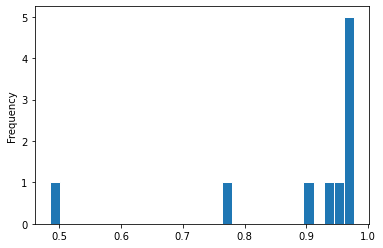

In [14]:
pd.DataFrame(random_forest.cv_results_)["mean_test_score"].plot.hist(bins=30, edgecolor="white")

In [15]:
pd.DataFrame(random_forest.cv_results_).sort_values(["mean_test_score"], ascending=False).head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,...,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
9,2.714,0.161,0.020,0.001,10,...,0.976,0.979,0.978,0.001,1
8,2.742,0.185,0.020,0.002,9,...,0.975,0.978,0.976,0.001,2
7,2.737,0.236,0.019,0.002,8,...,0.973,0.976,0.975,0.001,3


In [16]:
pd.DataFrame(random_forest.cv_results_).sort_values(["mean_test_score"], ascending=False).tail(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,...,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
2,1.136,0.106,0.016,0.004,3,...,0.915,0.900,0.906,0.006,8
1,0.948,0.150,0.018,0.006,2,...,0.800,0.756,0.776,0.012,9
0,0.558,0.113,0.016,0.005,1,...,0.496,0.478,0.484,0.015,10


In [68]:
regressor = RandomForestRegressor(random_state=0)
regressor.fit(data[X_vars], data[y_var])
from sklearn.model_selection import validation_curve
max_depth = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
scores = validation_curve(regressor, data[X_vars], data[y_var], param_name="max_depth", param_range=max_depth,
    cv=ShuffleSplit(n_splits=10, random_state=0), scoring="r2", n_jobs=2)

In [69]:
train_score = pd.DataFrame(scores[0])
test_score = pd.DataFrame(scores[1])

In [70]:
test_score_per_param = test_score.mean(axis=1)
train_score_per_param = train_score.mean(axis=1)

In [71]:
train_score_per_param 

0   0.481
1   0.777
2   0.911
3   0.945
4   0.960
5   0.969
6   0.975
7   0.979
8   0.983
9   0.986
dtype: float64

In [72]:
test_score_per_param

0   0.484
1   0.776
2   0.906
3   0.943
4   0.958
5   0.966
6   0.972
7   0.975
8   0.976
9   0.978
dtype: float64

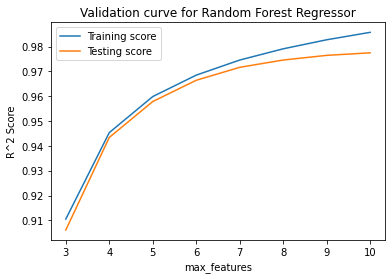

In [73]:
plt.plot(max_depth[2:], train_score_per_param[2:], label="Training score")
plt.plot(max_depth[2:], test_score_per_param[2:], label="Testing score")
plt.legend()
plt.xlabel("max_features")
plt.ylabel("R^2 Score")
_ = plt.title("Validation curve for Random Forest Regressor")

The fit of the random forest regression model is extremely high, with very little variation in the mean test scores.

Testing the fit of the model using nested cross validation:

In [ ]:
# hyperparameter parameter tuning with nested cross validation
random_forest = GridSearchCV(estimator=RandomForestRegressor(random_state=0), 
                   param_grid={'n_estimators':np.arange(100,200,10), 'max_features':np.round(np.arange(0.1,1.0,0.1),2)}, 
                   cv=ShuffleSplit(n_splits=10, random_state=0))
scores = cross_val_score(random_forest, X=data[X_vars], y=data[y_var], cv=ShuffleSplit(n_splits=10, random_state=1))

Due to the length of time required to run the above code, the results are described below:

In [17]:
scores = pd.DataFrame(np.array([0.98167764, 0.97751271, 0.98074357, 0.97641228, 0.97778619,
       0.97649653, 0.97802428, 0.97883394, 0.97738861, 0.97887816])).transpose()

In [18]:
scores.columns=[f"Run {num}" for num in range(1, 11)]

In [19]:
scores

,Run 1,Run 2,Run 3,Run 4,Run 5,Run 6,Run 7,Run 8,Run 9,Run 10
0,0.982,0.978,0.981,0.976,0.978,0.976,0.978,0.979,0.977,0.979


In [20]:
scores.transpose()[0].describe().drop("25%").drop("50%").drop("75%").drop("count")

mean   0.978
std    0.002
min    0.976
max    0.982
Name: 0, dtype: float64

Creating a model from the full data, using the best hyperparameter found in cross validation:

In [21]:
forest_model = RandomForestRegressor(random_state=0, n_estimators=180, max_features=0.6)
forest_model.fit(data[X_vars].values, data[y_var].values)

RandomForestRegressor(max_features=0.6, n_estimators=180, random_state=0)

Looking at feature importance in the random forest regressor model:

The number of fridges in a heat pump group corresponds most strongly to the chillingPower required for the heatpump, as does the temperature of the fridge, and temperature of the evaporator. The "before_after_seal" variable is extremely low down in the list.

The categorical heat pump variables, unlike in the linear regression model, are much further down in the feature importance list, and have little importance to the model. This is very different to the linear regression model, where these attributes had some of the largest coefficients.

Text(0, 0.5, 'Feature Importance')

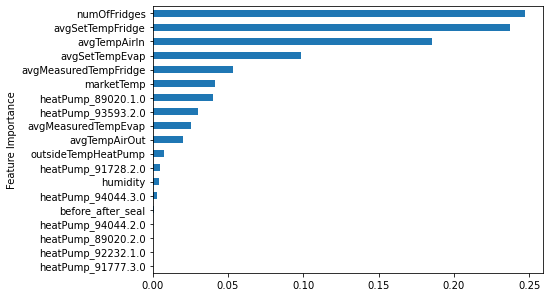

In [22]:
plt.figure(figsize=(7, 4.9))
ax = pd.Series(forest_model.feature_importances_, index=data[X_vars].columns).sort_values(ascending=True).plot.barh()
ax.set_ylabel("Feature Importance")

<AxesSubplot:>

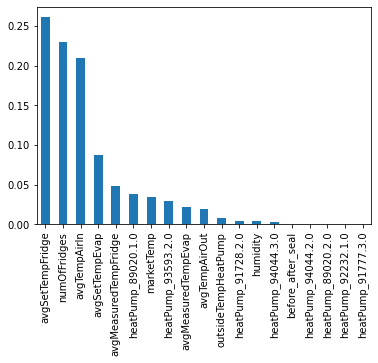

In [23]:
forest_model = RandomForestRegressor(random_state=0, n_estimators=180, max_features=0.6)
forest_model.fit(data_norm[X_vars].values, data_norm[y_var].values)
pd.Series(forest_model.feature_importances_, index=data[X_vars].columns).sort_values(ascending=False).plot.bar()

## Fitting a model to each of the heat pump datasets individually<a name="pumpsmodel"></a>

Even within one heat pump, are different types of fridges with different set points: be aware of this!

In [24]:
fridgesinhp = pd.DataFrame(fridges.groupby("uniqueHpId")["setTempFridge"].unique()).reset_index()

In [25]:
fridgesinhp[fridgesinhp["uniqueHpId"].isin(list(data["uniqueHpId"].unique()))]

,uniqueHpId,setTempFridge
17,89020.1.0,[6.0]
18,89020.2.0,[1.0]
19,91728.2.0,"[6.0, 1.0]"
21,91777.3.0,[1.0]
22,92232.1.0,"[6.0, 1.0, 10.0]"
24,93593.2.0,"[6.0, 1.0, nan]"
26,94044.2.0,[6.0]
27,94044.3.0,"[1.0, nan]"


In [26]:
pump_models={}
for hp in pumps.keys():
    pump_models[hp]=[]
    pump_model = sm.OLS(pumps_norm[hp][y_var], sm.add_constant(pumps_norm[hp][X_vars[:11]])).fit()
    pump_models[hp] = [pump_model.rsquared, 
                       pump_model.params["before_after_seal"], 
                       pump_model.pvalues["before_after_seal"],
                       pumps[hp]["numOfFridges"][0]]

In [27]:
pump_models_results = pd.DataFrame.from_dict(pump_models, orient="index").reset_index()
pump_models_results.columns = ["heatPumpId", "RSquared", "sealChange_Coef", "sealChange_p-Value", "numOfFridgesInHeatPump"]
pump_models_results.sort_values("sealChange_p-Value")

,heatPumpId,RSquared,sealChange_Coef,sealChange_p-Value,numOfFridgesInHeatPump
2,91728.2.0,0.716,0.775,0.000,11
1,89020.2.0,0.660,0.293,0.000,1
5,93593.2.0,0.687,0.145,0.000,13
4,92232.1.0,0.913,0.037,0.008,12
7,94044.3.0,0.662,-0.096,0.011,1
3,91777.3.0,0.525,-0.097,0.016,1
0,89020.1.0,0.647,0.045,0.247,12
6,94044.2.0,0.597,-0.051,0.252,10


In [28]:
pump_models_results["abs_coef"] = pump_models_results["sealChange_Coef"].abs()

In [29]:
pump_models_results.sort_values("abs_coef", ascending=False)

,heatPumpId,RSquared,sealChange_Coef,sealChange_p-Value,numOfFridgesInHeatPump,abs_coef
2,91728.2.0,0.716,0.775,0.000,11,0.775
1,89020.2.0,0.660,0.293,0.000,1,0.293
5,93593.2.0,0.687,0.145,0.000,13,0.145
3,91777.3.0,0.525,-0.097,0.016,1,0.097
7,94044.3.0,0.662,-0.096,0.011,1,0.096
6,94044.2.0,0.597,-0.051,0.252,10,0.051
0,89020.1.0,0.647,0.045,0.247,12,0.045
4,92232.1.0,0.913,0.037,0.008,12,0.037


In [30]:
pump_models_results.sort_values("RSquared", ascending=False)

,heatPumpId,RSquared,sealChange_Coef,sealChange_p-Value,numOfFridgesInHeatPump,abs_coef
4,92232.1.0,0.913,0.037,0.008,12,0.037
2,91728.2.0,0.716,0.775,0.000,11,0.775
5,93593.2.0,0.687,0.145,0.000,13,0.145
7,94044.3.0,0.662,-0.096,0.011,1,0.096
1,89020.2.0,0.660,0.293,0.000,1,0.293
0,89020.1.0,0.647,0.045,0.247,12,0.045
6,94044.2.0,0.597,-0.051,0.252,10,0.051
3,91777.3.0,0.525,-0.097,0.016,1,0.097


Looking at only the significant p-values, the coefficient for the before_after_seal attribute is positive, suggesting that it has increased the amount of chillingPower required.

However the R squared values of these models are relatively low, suggesting that the data does not explain the differences in chillingPower particularly well, and there is a lot of structure in the data not explained by the model.

What do the heatpumps have in common, that mean that their R squared value is higher?

In [31]:
pump_models={}
for hp in pumps.keys():
    pump_models[hp]=[]
    pump_model = sm.OLS(pumps[hp][y_var], sm.add_constant(pumps[hp][X_vars[:11]])).fit()
    pump_models[hp] = [pump_model.rsquared, 
                       pump_model.params["before_after_seal"], 
                       pump_model.pvalues["before_after_seal"],
                       pumps[hp]["numOfFridges"][0]]

In [32]:
pump_models_results = pd.DataFrame.from_dict(pump_models, orient="index").reset_index()
pump_models_results.columns = ["heatPumpId", "modelRSquared", "before_after_sealCoefficient", "before_after_sealP-Value", "numOfFridgesInHeatPump"]
pump_models_results.sort_values("modelRSquared", ascending=False)

,heatPumpId,modelRSquared,before_after_sealCoefficient,before_after_sealP-Value,numOfFridgesInHeatPump
4,92232.1.0,0.915,0.410,0.000,12
2,91728.2.0,0.716,2.753,0.000,11
5,93593.2.0,0.704,1.620,0.000,13
7,94044.3.0,0.662,-0.094,0.011,1
1,89020.2.0,0.660,0.516,0.000,1
0,89020.1.0,0.647,0.047,0.247,12
6,94044.2.0,0.597,-0.121,0.252,10
3,91777.3.0,0.525,-0.116,0.016,1


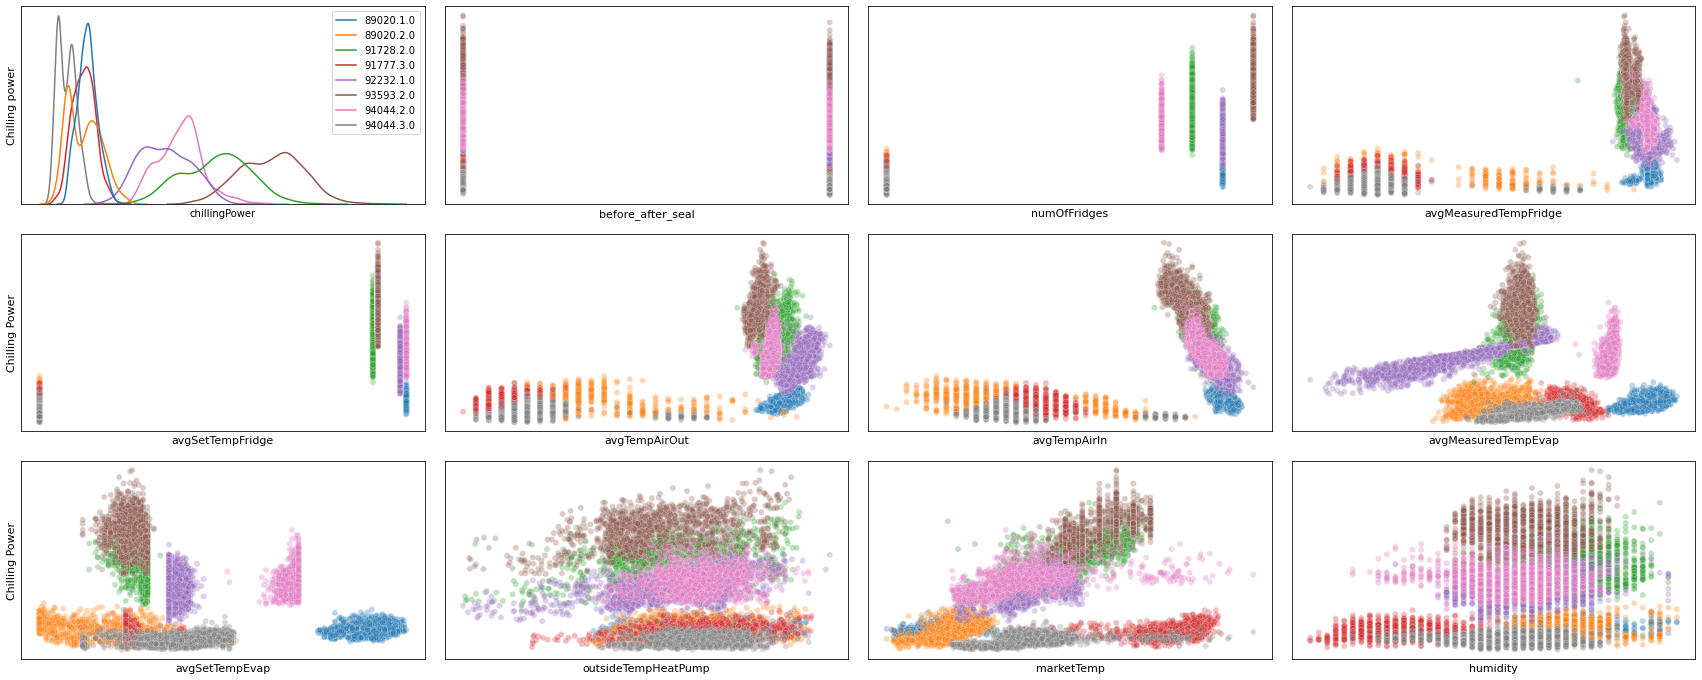

In [33]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(30,12))
fig.subplots_adjust(wspace=0.05, hspace=0.15)
sns.kdeplot(data=data, x="chillingPower", hue="uniqueHpId", multiple="layer", ax=axes.ravel()[0])
axes.ravel()[0].set_ylabel("Chilling power", fontsize=11)
axes.ravel()[4].set_ylabel("Chilling Power", fontsize=11)
axes.ravel()[8].set_ylabel("Chilling Power", fontsize=11)
axes.ravel()[0].set_xticks(()), axes.ravel()[0].set_yticks(()), axes.ravel()[0].legend_.set_title(None)
for i in range(0, 11):
    ax = axes.ravel()[i+1]
    ax.set_xticks(()), ax.set_yticks(()), ax.set_xlabel(X_vars[:11][i], fontsize=11)
    sns.scatterplot(data=data, y="chillingPower", x=X_vars[:11][i], hue="uniqueHpId", alpha=0.3, ax=ax, legend=False)

The wildly varying model fits indicate that the different heat pumps have strong differences between them, not explained in the data provided.

The blue and pink heat pump groups do not have a significant heat pump change coefficient.  
The purple heat pump group has the highest fitting model. 

## Only looking at observations recorded between 1am and 4am<a name="night"></a>

The effect of customers opening the fridge doors will have a large effect on the fridges - much larger than that of the door seal. Therefore by looking only at data occurring between 1am and 4am, we could assume that no one is opening the doors at this time.

In [34]:
night_data = data.set_index("date").between_time("01:00", "04:00")

In [35]:
night_data_norm = data_norm.set_index("date").between_time("01:00", "04:00")

In [36]:
stats_model = sm.OLS(night_data[y_var], sm.add_constant(night_data[X_vars])).fit()
stats_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          chillingPower   R-squared:                       0.957
Model:                            OLS   Adj. R-squared:                  0.957
Method:                 Least Squares   F-statistic:                     2453.
Date:                Fri, 03 Feb 2023   Prob (F-statistic):               0.00
Time:                        11:45:39   Log-Likelihood:                -3280.5
No. Observations:                1780   AIC:                             6595.
Df Residuals:                    1763   BIC:                             6688.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -3.1918      0.955     -3.341      0.001      -5.065      -1.318
before_after_seal        -0.6482      0.089     -7.259      0.000      -0.823      -0.473
numOfFridges              1.8891      0.049     38.380      0.000       1.793       1.986
avgMeasuredTempFridge     1.3192      0.439      3.007      0.003       0.459       2.180
avgSetTempFridge         -2.1790      0.180    -12.112      0.000      -2.532      -1.826
avgTempAirOut            -0.6858      0.292     -2.350      0.019      -1.258      -0.114
avgTempAirIn             -0.4734      0.213     -2.223      0.026      -0.891      -0.056
avgMeasuredTempEvap       0.6052      0.058     10.483      0.000       0.492       0.718
avgSetTempEvap           -0.6799      0.087     -7.793      0.000      -0.851      -0.509
outsideTempHeatPump       0.0965      0.016      6.168      0.000       0.066       0.127
marketTemp                0.4064      0.066      6.134      0.000       0.276       0.536
humidity                  0.0127      0.015      0.868      0.385      -0.016       0.041
heatPump_89020.1.0       -9.2254      0.345    -26.776      0.000      -9.901      -8.550
heatPump_89020.2.0        0.3438      0.376      0.915      0.360      -0.393       1.080
heatPump_91728.2.0        3.2206      0.193     16.691      0.000       2.842       3.599
heatPump_91777.3.0       -3.2837      0.571     -5.754      0.000      -4.403      -2.164
heatPump_92232.1.0       -0.1894      0.306     -0.618      0.536      -0.790       0.411
heatPump_93593.2.0        4.4038      0.242     18.222      0.000       3.930       4.878
heatPump_94044.2.0        2.6213      0.261     10.060      0.000       2.110       3.132
heatPump_94044.3.0       -1.0828      0.367     -2.952      0.003      -1.802      -0.364
==============================================================================
Omnibus:                      272.355   Durbin-Watson:                   2.040
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              789.094
Skew:                           0.793   Prob(JB):                    4.47e-172
Kurtosis:                       5.850   Cond. No.                     3.26e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.43e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [37]:
stats_model = sm.OLS(night_data[y_var], sm.add_constant(night_data_norm[X_vars])).fit()
stats_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          chillingPower   R-squared:                       0.957
Model:                            OLS   Adj. R-squared:                  0.957
Method:                 Least Squares   F-statistic:                     2453.
Date:                Fri, 03 Feb 2023   Prob (F-statistic):               0.00
Time:                        11:45:39   Log-Likelihood:                -3280.5
No. Observations:                1780   AIC:                             6595.
Df Residuals:                    1763   BIC:                             6688.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     9.8565      0.067    147.541      0.000       9.725       9.988
before_after_seal        -0.6482      0.089     -7.259      0.000      -0.823      -0.473
numOfFridges              3.6359      0.086     42.180      0.000       3.467       3.805
avgMeasuredTempFridge     3.0710      1.021      3.007      0.003       1.068       5.074
avgSetTempFridge          1.3664      0.097     14.128      0.000       1.177       1.556
avgTempAirOut            -1.6071      0.684     -2.350      0.019      -2.948      -0.266
avgTempAirIn             -1.1101      0.499     -2.223      0.026      -2.090      -0.131
avgMeasuredTempEvap       1.6897      0.161     10.483      0.000       1.374       2.006
avgSetTempEvap           -1.4287      0.183     -7.793      0.000      -1.788      -1.069
outsideTempHeatPump       0.3484      0.056      6.168      0.000       0.238       0.459
marketTemp                0.9243      0.151      6.134      0.000       0.629       1.220
humidity                  0.0959      0.110      0.868      0.385      -0.121       0.312
heatPump_89020.1.0       -7.8974      0.316    -25.008      0.000      -8.517      -7.278
heatPump_89020.2.0        2.4221      0.257      9.438      0.000       1.919       2.925
heatPump_91728.2.0        4.6168      0.197     23.443      0.000       4.231       5.003
heatPump_91777.3.0       -1.2054      0.347     -3.479      0.001      -1.885      -0.526
heatPump_92232.1.0        1.3690      0.316      4.334      0.000       0.750       1.988
heatPump_93593.2.0        7.9832      0.218     36.639      0.000       7.556       8.411
heatPump_94044.2.0        1.5728      0.202      7.778      0.000       1.176       1.969
heatPump_94044.3.0        0.9954      0.140      7.132      0.000       0.722       1.269
==============================================================================
Omnibus:                      272.355   Durbin-Watson:                   2.040
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              789.094
Skew:                           0.793   Prob(JB):                    4.47e-172
Kurtosis:                       5.850   Cond. No.                     1.28e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 5.74e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [38]:
stats_model.params.abs().sort_values(ascending=False)

const                   9.857
heatPump_93593.2.0      7.983
heatPump_89020.1.0      7.897
heatPump_91728.2.0      4.617
numOfFridges            3.636
avgMeasuredTempFridge   3.071
heatPump_89020.2.0      2.422
avgMeasuredTempEvap     1.690
avgTempAirOut           1.607
heatPump_94044.2.0      1.573
avgSetTempEvap          1.429
heatPump_92232.1.0      1.369
avgSetTempFridge        1.366
heatPump_91777.3.0      1.205
avgTempAirIn            1.110
heatPump_94044.3.0      0.995
marketTemp              0.924
before_after_seal       0.648
outsideTempHeatPump     0.348
humidity                0.096
dtype: float64

In [39]:
pump_models={}
for hp in pumps.keys():
    pump_models[hp]=[]
    pump_data = pumps[hp].set_index("date").between_time("01:00", "04:00")
    pump_model = sm.OLS(pump_data[y_var], sm.add_constant(pump_data[X_vars[:11]])).fit()
    pump_models[hp] = [pump_model.rsquared, 
                       pump_model.params["before_after_seal"], 
                       pump_model.pvalues["before_after_seal"],
                       pumps[hp]["numOfFridges"][0]]
pump_models_results = pd.DataFrame.from_dict(pump_models, orient="index").reset_index()
pump_models_results.columns = ["heatPumpId", "modelRSquared", "before_after_sealCoefficient", "before_after_sealP-Value", "numOfFridgesInHeatPump"]
pump_models_results.sort_values("before_after_sealP-Value")

,heatPumpId,modelRSquared,before_after_sealCoefficient,before_after_sealP-Value,numOfFridgesInHeatPump
6,94044.2.0,0.560,-1.047,0.000,10
7,94044.3.0,0.554,-0.127,0.007,1
2,91728.2.0,0.803,-1.982,0.028,11
0,89020.1.0,0.636,-0.209,0.035,12
4,92232.1.0,0.730,0.679,0.049,12
1,89020.2.0,0.351,0.138,0.097,1
5,93593.2.0,0.648,-0.769,0.263,13
3,91777.3.0,0.423,0.064,0.527,1


In [40]:
pump_models={}
for hp in pumps.keys():
    pump_models[hp]=[]
    pump_data = pumps[hp].set_index("date").between_time("01:00", "04:00")
    pump_data_norm = pumps_norm[hp].set_index("date").between_time("01:00", "04:00")
    pump_model = sm.OLS(pump_data[y_var], sm.add_constant(pump_data_norm[X_vars[:11]])).fit()
    pump_models[hp] = [pump_model.rsquared, 
                       pump_model.params["before_after_seal"], 
                       pump_model.pvalues["before_after_seal"],
                       pumps[hp]["numOfFridges"][0]]
pump_models_results = pd.DataFrame.from_dict(pump_models, orient="index").reset_index()
pump_models_results.columns = ["heatPumpId", "modelRSquared", "before_after_sealCoefficient", "before_after_sealP-Value", "numOfFridgesInHeatPump"]
pump_models_results.sort_values("before_after_sealP-Value")

,heatPumpId,modelRSquared,before_after_sealCoefficient,before_after_sealP-Value,numOfFridgesInHeatPump
6,94044.2.0,0.560,-1.047,0.000,10
7,94044.3.0,0.554,-0.127,0.007,1
2,91728.2.0,0.803,-1.982,0.028,11
0,89020.1.0,0.636,-0.209,0.035,12
1,89020.2.0,0.351,0.138,0.097,1
3,91777.3.0,0.423,0.064,0.527,1
5,93593.2.0,-10.680,0.608,0.877,13
4,92232.1.0,-8.173,-0.011,0.995,12


In [41]:
pump_models={}
for hp in pumps.keys():
    pump_models[hp]=[]
    pump_data = pumps[hp].set_index("date").between_time("01:00", "04:00")
    pump_data_norm = pumps_norm[hp].set_index("date").between_time("01:00", "04:00")
    pump_model = sm.OLS(pump_data_norm[y_var], sm.add_constant(pump_data_norm[X_vars[:11]])).fit()
    pump_models[hp] = [pump_model.rsquared, 
                       pump_model.params["before_after_seal"], 
                       pump_model.pvalues["before_after_seal"],
                       pumps[hp]["numOfFridges"][0]]
pump_models_results = pd.DataFrame.from_dict(pump_models, orient="index").reset_index()
pump_models_results.columns = ["heatPumpId", "RSquared", "sealChange_Coef", "sealChange_p-Value", "numOfFridgesInHeatPump"]
pump_models_results["abs_coef"] = pump_models_results["sealChange_Coef"].abs()
pump_models_results.sort_values("abs_coef", ascending=False).drop(5)

,heatPumpId,RSquared,sealChange_Coef,sealChange_p-Value,numOfFridgesInHeatPump,abs_coef
2,91728.2.0,0.803,-0.558,0.028,11,0.558
6,94044.2.0,0.560,-0.447,0.000,10,0.447
4,92232.1.0,0.711,0.262,0.045,12,0.262
0,89020.1.0,0.636,-0.201,0.035,12,0.201
7,94044.3.0,0.554,-0.128,0.007,1,0.128
1,89020.2.0,0.351,0.078,0.097,1,0.078
3,91777.3.0,0.423,0.054,0.527,1,0.054


<AxesSubplot:>

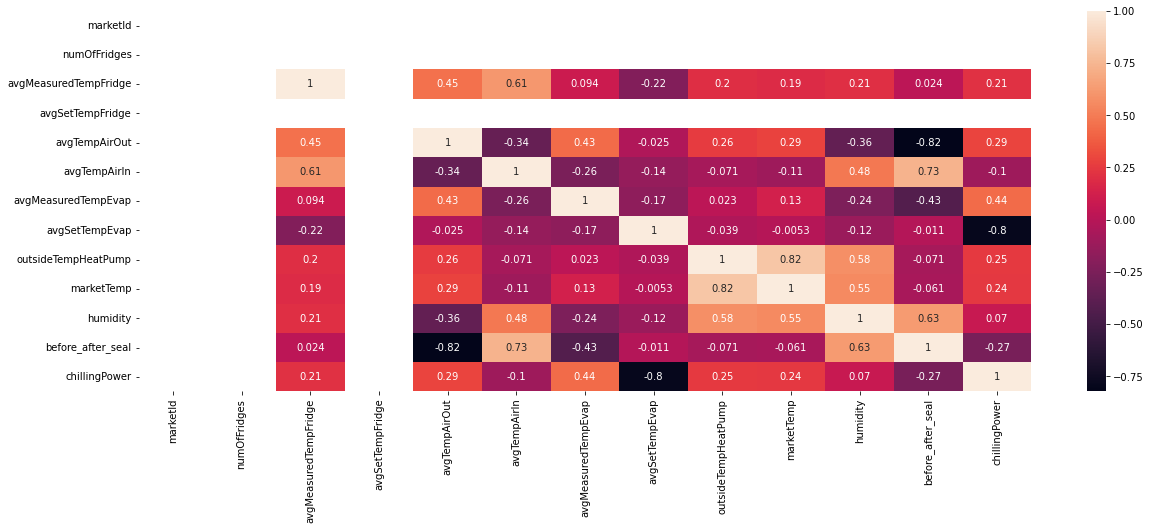

In [43]:
plt.figure(figsize=(20, 7))
sns.heatmap(pumps["91728.2.0"].set_index("date").between_time("01:00", "04:00").corr(),annot=True)

In [44]:
pump_data_norm = pumps_norm["91728.2.0"].set_index("date").between_time("01:00", "04:00")
pump_model = sm.OLS(pump_data_norm[y_var], sm.add_constant(pump_data_norm[X_vars[:11]])).fit()
pump_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          chillingPower   R-squared:                       0.803
Model:                            OLS   Adj. R-squared:                  0.795
Method:                 Least Squares   F-statistic:                     96.96
Date:                Fri, 03 Feb 2023   Prob (F-statistic):           1.71e-70
Time:                        11:45:51   Log-Likelihood:                -124.57
No. Observations:                 224   AIC:                             269.1
Df Residuals:                     214   BIC:                             303.3
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.2966      0.091      3.243      0.001       0.116       0.477
before_after_seal        -0.5579      0.252     -2.218      0.028      -1.054      -0.062
numOfFridges           2.387e-17   6.42e-17      0.372      0.711   -1.03e-16     1.5e-16
avgMeasuredTempFridge     0.0797      0.098      0.813      0.417      -0.113       0.273
avgSetTempFridge       3.033e-16    1.8e-16      1.682      0.094   -5.21e-17    6.59e-16
avgTempAirOut            -0.1633      0.131     -1.245      0.215      -0.422       0.095
avgTempAirIn             -0.0567      0.149     -0.379      0.705      -0.351       0.238
avgMeasuredTempEvap       0.2242      0.035      6.451      0.000       0.156       0.293
avgSetTempEvap           -0.9652      0.043    -22.339      0.000      -1.050      -0.880
outsideTempHeatPump       0.0821      0.057      1.450      0.148      -0.029       0.194
marketTemp                0.1501      0.089      1.677      0.095      -0.026       0.326
humidity                  0.0688      0.078      0.879      0.380      -0.085       0.223
==============================================================================
Omnibus:                        0.609   Durbin-Watson:                   1.946
Prob(Omnibus):                  0.738   Jarque-Bera (JB):                0.515
Skew:                           0.117   Prob(JB):                        0.773
Kurtosis:                       3.009   Cond. No.                     1.49e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is  4e-32. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [45]:
pump_models_results.sort_values("RSquared", ascending=False)

,heatPumpId,RSquared,sealChange_Coef,sealChange_p-Value,numOfFridgesInHeatPump,abs_coef
2,91728.2.0,0.803,-0.558,0.028,11,0.558
4,92232.1.0,0.711,0.262,0.045,12,0.262
5,93593.2.0,0.647,-0.227,0.269,13,0.227
0,89020.1.0,0.636,-0.201,0.035,12,0.201
6,94044.2.0,0.560,-0.447,0.000,10,0.447
7,94044.3.0,0.554,-0.128,0.007,1,0.128
3,91777.3.0,0.423,0.054,0.527,1,0.054
1,89020.2.0,0.351,0.078,0.097,1,0.078


Looking only at the data between 1am and 4am, if the effect of the door seal change has a significant p value, then then coefficient of this feature is negative, suggesting that the door seal change has reduced the amount of energy required to cool the fridges.

This is the opposite effect to that found when examining all of the data, which tended to find a positive coefficient, suggesting that the effect of customers using the fridges obscured the relationship.

In [46]:
pump_models={}
for hp in pumps.keys():
    pump_models[hp]=[]
    pump_data = pumps[hp].set_index("date").between_time("01:00", "04:00")
    pump_model = sm.OLS(pump_data[y_var], sm.add_constant(pump_data[X_vars[:11]])).fit()
    pump_models[hp] = [pump_model.rsquared, 
                       pump_model.params["before_after_seal"], 
                       pump_model.pvalues["before_after_seal"],
                       pumps[hp]["numOfFridges"][0]]
pump_models_results = pd.DataFrame.from_dict(pump_models, orient="index").reset_index()
pump_models_results.columns = ["heatPumpId", "night_modelRSquared", "night_Coefficient", "night_P-Value", "numOfFridgesInHeatPump"]
pump_models_results.sort_values("night_P-Value")
night_data_pump_results = pump_models_results.set_index("heatPumpId")

In [47]:
pump_models={}
for hp in pumps.keys():
    pump_models[hp]=[]
    pump_model = sm.OLS(pumps[hp][y_var], sm.add_constant(pumps[hp][X_vars[:11]])).fit()
    pump_models[hp] = [pump_model.rsquared, 
                       pump_model.params["before_after_seal"], 
                       pump_model.pvalues["before_after_seal"],
                       pumps[hp]["numOfFridges"][0]]
pump_models_results = pd.DataFrame.from_dict(pump_models, orient="index").reset_index()
pump_models_results.columns = ["heatPumpId", "all_modelRSquared", "all_Coefficient", "all_P-Value", "numOfFridgesInHeatPump"]
pump_models_results.sort_values("all_P-Value")
all_data_pump_results = pump_models_results.set_index("heatPumpId")

In [48]:
pd.concat([all_data_pump_results, night_data_pump_results], axis=1).iloc[:, :7][["all_modelRSquared", "night_modelRSquared", "all_Coefficient", "night_Coefficient",
                                                                                 "all_P-Value", "night_P-Value", "numOfFridgesInHeatPump"]].sort_values("night_P-Value")

,all_modelRSquared,night_modelRSquared,all_Coefficient,night_Coefficient,all_P-Value,night_P-Value,numOfFridgesInHeatPump
heatPumpId,,,,,,,
94044.2.0,0.597,0.560,-0.121,-1.047,0.252,0.000,10
94044.3.0,0.662,0.554,-0.094,-0.127,0.011,0.007,1
91728.2.0,0.716,0.803,2.753,-1.982,0.000,0.028,11
89020.1.0,0.647,0.636,0.047,-0.209,0.247,0.035,12
92232.1.0,0.915,0.730,0.410,0.679,0.000,0.049,12
89020.2.0,0.660,0.351,0.516,0.138,0.000,0.097,1
93593.2.0,0.704,0.648,1.620,-0.769,0.000,0.263,13
91777.3.0,0.525,0.423,-0.116,0.064,0.016,0.527,1


In [49]:
pd.concat([all_data_pump_results, night_data_pump_results], axis=1).iloc[:, :7][["all_modelRSquared", "night_modelRSquared", "all_Coefficient", "night_Coefficient",
                                                                                 "all_P-Value", "night_P-Value", "numOfFridgesInHeatPump"]].sort_values("all_P-Value")

,all_modelRSquared,night_modelRSquared,all_Coefficient,night_Coefficient,all_P-Value,night_P-Value,numOfFridgesInHeatPump
heatPumpId,,,,,,,
91728.2.0,0.716,0.803,2.753,-1.982,0.000,0.028,11
93593.2.0,0.704,0.648,1.620,-0.769,0.000,0.263,13
89020.2.0,0.660,0.351,0.516,0.138,0.000,0.097,1
92232.1.0,0.915,0.730,0.410,0.679,0.000,0.049,12
94044.3.0,0.662,0.554,-0.094,-0.127,0.011,0.007,1
91777.3.0,0.525,0.423,-0.116,0.064,0.016,0.527,1
89020.1.0,0.647,0.636,0.047,-0.209,0.247,0.035,12
94044.2.0,0.597,0.560,-0.121,-1.047,0.252,0.000,10


## Looking at individual heat pumps<a name="indiv"></a>

Working on three heat pumps:  
92232.1.0: it had the best fitting model, and showed some correlation in the plots. It had positive but small coef for seal.  Multiple fridges in group.  
94044.3.0: it had a negative coef for seal, and only one fridge in its group.  
89020.2.0: it had a positive coef for seal, and only one fridge in its group.

In [50]:
strong_pump = pumps["92232.1.0"] 
strong_pump_norm = pumps_norm["92232.1.0"]

In [51]:
neg_coef = pumps["94044.3.0"] 
neg_coef_norm = pumps_norm["94044.3.0"]

In [52]:
pos_coef = pumps["89020.2.0"] 
pos_coef_norm = pumps_norm["89020.2.0"]

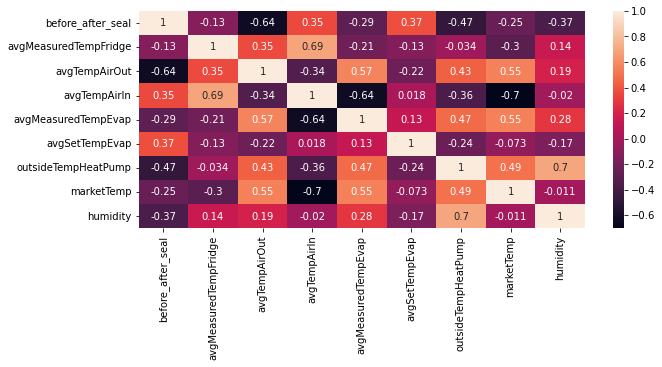

In [53]:
plt.figure(figsize=(10, 4))
sns.heatmap(strong_pump[['before_after_seal','avgMeasuredTempFridge','avgTempAirOut','avgTempAirIn','avgMeasuredTempEvap','avgSetTempEvap','outsideTempHeatPump','marketTemp','humidity']].corr(), annot=True);

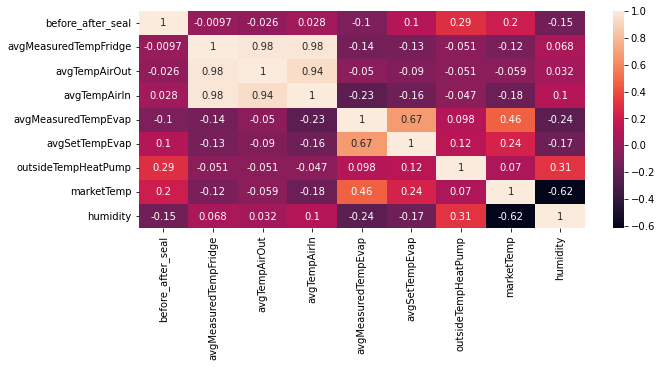

In [54]:
plt.figure(figsize=(10, 4))
sns.heatmap(neg_coef[['before_after_seal','avgMeasuredTempFridge','avgTempAirOut','avgTempAirIn','avgMeasuredTempEvap','avgSetTempEvap','outsideTempHeatPump','marketTemp','humidity']].corr(), annot=True);

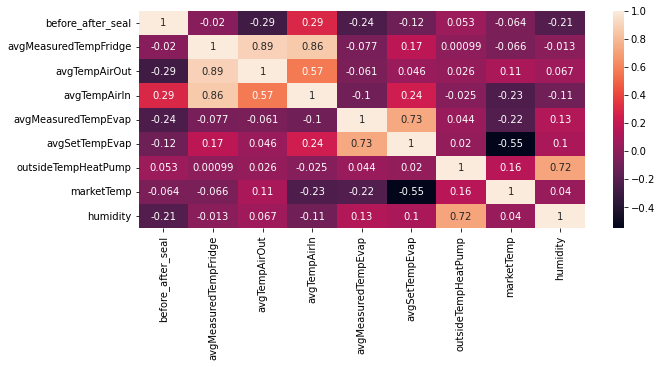

In [55]:
plt.figure(figsize=(10, 4))
sns.heatmap(pos_coef[['before_after_seal','avgMeasuredTempFridge','avgTempAirOut','avgTempAirIn','avgMeasuredTempEvap','avgSetTempEvap','outsideTempHeatPump','marketTemp','humidity']].corr(), annot=True);

<AxesSubplot:xlabel='avgTempAirIn', ylabel='avgTempAirOut'>

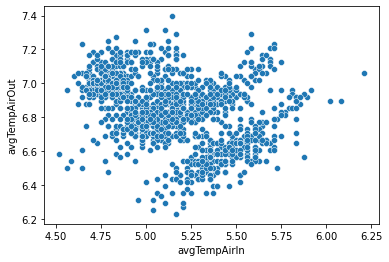

In [56]:
sns.scatterplot(data=strong_pump, x="avgTempAirIn", y="avgTempAirOut")

<AxesSubplot:xlabel='avgTempAirIn', ylabel='avgTempAirOut'>

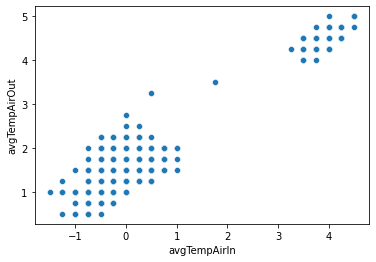

In [61]:
sns.scatterplot(data=neg_coef, x="avgTempAirIn", y="avgTempAirOut")

<AxesSubplot:xlabel='avgTempAirIn', ylabel='avgTempAirOut'>

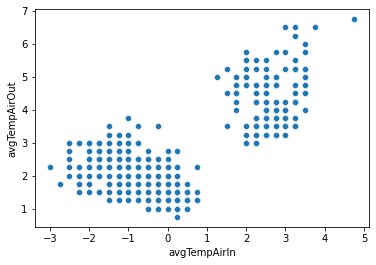

In [62]:
sns.scatterplot(data=pos_coef, x="avgTempAirIn", y="avgTempAirOut")

Different fridges within the heatpump have different relationships between the variables. e.g. some fridges have positive relationship, others negative.

Looks like clusters: could be multiple different types of fridges within the group.

When there is only one fridge within the heat pump group, the relationship is clearer.

The relationships between the variables are completely different for each of the heatpumps. e.g. for the first two heatpumps, tempairout and tempairin have no relationship, as would be expected.

### 92232.1.0 - strong pump<a name="pump1"></a>

Basic model

In [58]:
stats_model = sm.OLS(strong_pump[y_var], sm.add_constant(strong_pump[X_vars[:11]])).fit()
stats_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          chillingPower   R-squared:                       0.915
Model:                            OLS   Adj. R-squared:                  0.914
Method:                 Least Squares   F-statistic:                     1590.
Date:                Fri, 03 Feb 2023   Prob (F-statistic):               0.00
Time:                        11:45:58   Log-Likelihood:                -1595.3
No. Observations:                1344   AIC:                             3211.
Df Residuals:                    1334   BIC:                             3263.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
before_after_seal         0.4098      0.076      5.373      0.000       0.260       0.559
numOfFridges              0.2982      0.115      2.594      0.010       0.073       0.524
avgMeasuredTempFridge     2.0879      0.453      4.610      0.000       1.199       2.976
avgSetTempFridge          0.1470      0.057      2.594      0.010       0.036       0.258
avgTempAirOut             1.2571      0.317      3.970      0.000       0.636       1.878
avgTempAirIn             -2.7168      0.241    -11.285      0.000      -3.189      -2.245
avgMeasuredTempEvap       0.7987      0.017     47.260      0.000       0.766       0.832
avgSetTempEvap           -1.5808      0.159     -9.936      0.000      -1.893      -1.269
outsideTempHeatPump       0.0392      0.010      4.018      0.000       0.020       0.058
marketTemp               -0.0116      0.063     -0.184      0.854      -0.136       0.112
humidity                  0.0308      0.008      3.937      0.000       0.015       0.046
==============================================================================
Omnibus:                        8.837   Durbin-Watson:                   1.710
Prob(Omnibus):                  0.012   Jarque-Bera (JB):               11.596
Skew:                           0.058   Prob(JB):                      0.00303
Kurtosis:                       3.440   Cond. No.                     2.05e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 9.18e-27. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [59]:
stats_model = sm.OLS(strong_pump_norm[y_var], sm.add_constant(strong_pump_norm[X_vars[:11]])).fit()
stats_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          chillingPower   R-squared:                       0.913
Model:                            OLS   Adj. R-squared:                  0.913
Method:                 Least Squares   F-statistic:                     1758.
Date:                Fri, 03 Feb 2023   Prob (F-statistic):               0.00
Time:                        11:45:58   Log-Likelihood:                -263.72
No. Observations:                1344   AIC:                             545.4
Df Residuals:                    1335   BIC:                             592.3
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
before_after_seal         0.0369      0.014      2.638      0.008       0.009       0.064
numOfFridges            7.81e-17   1.96e-17      3.993      0.000    3.97e-17    1.16e-16
avgMeasuredTempFridge     0.1062      0.023      4.557      0.000       0.060       0.152
avgSetTempFridge      -6.031e-17   2.58e-17     -2.334      0.020   -1.11e-16   -9.62e-18
avgTempAirOut             0.0442      0.021      2.151      0.032       0.004       0.084
avgTempAirIn             -0.2585      0.025    -10.297      0.000      -0.308      -0.209
avgMeasuredTempEvap       0.7219      0.014     51.523      0.000       0.694       0.749
avgSetTempEvap           -0.0867      0.009     -9.383      0.000      -0.105      -0.069
outsideTempHeatPump       0.0512      0.016      3.196      0.001       0.020       0.083
marketTemp                0.0265      0.015      1.712      0.087      -0.004       0.057
humidity                  0.0482      0.014      3.415      0.001       0.021       0.076
==============================================================================
Omnibus:                       10.544   Durbin-Watson:                   1.676
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               14.278
Skew:                           0.070   Prob(JB):                     0.000794
Kurtosis:                       3.485   Cond. No.                     3.64e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.38e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Cross validation on basic model

In [60]:
kfcv_results = pd.DataFrame(cross_validate(LinearRegression(), strong_pump[X_vars[:11]].values, strong_pump[y_var].values, 
                                           cv=ShuffleSplit(n_splits=10, random_state=0), scoring="r2", return_train_score=True))
kfcv_results

,fit_time,score_time,test_score,train_score
0,0.002,0.000,0.923,0.914
1,0.001,0.000,0.926,0.913
2,0.001,0.000,0.904,0.916
3,0.001,0.000,0.906,0.915
4,0.001,0.000,0.885,0.917
5,0.001,0.000,0.908,0.915
6,0.001,0.000,0.916,0.915
7,0.001,0.000,0.911,0.915
8,0.001,0.000,0.902,0.916
9,0.001,0.000,0.911,0.915


Depending on which variables are included in the model, the sign of the coefficient of the before_after_seal changes

In [63]:
# limited set of variables
stats_model = sm.OLS(strong_pump_norm[y_var], sm.add_constant(strong_pump_norm[["before_after_seal", "avgMeasuredTempFridge", "avgMeasuredTempEvap", "outsideTempHeatPump", "marketTemp", "humidity"]])).fit()
print("param:", np.round(stats_model.params["before_after_seal"], 5), "p-value:", np.round(stats_model.pvalues["before_after_seal"], 5), "rsquared:", np.round(stats_model.rsquared, 3))

param: -0.16768 p-value: 0.0 rsquared: 0.894


In [64]:
# fuller set of variables
stats_model = sm.OLS(strong_pump_norm[y_var], sm.add_constant(strong_pump_norm\
 [["before_after_seal", "numOfFridges", "avgSetTempFridge", "avgMeasuredTempFridge", "avgSetTempEvap", "avgMeasuredTempEvap", "outsideTempHeatPump", "marketTemp", "humidity"]])).fit()
print("param:", np.round(stats_model.params["before_after_seal"], 5), "p-value:", np.round(stats_model.pvalues["before_after_seal"], 5), "rsquared:", np.round(stats_model.rsquared, 3))

param: -0.03746 p-value: 0.00494 rsquared: 0.902


In [65]:
# full with temp air in
stats_model = sm.OLS(strong_pump_norm[y_var], sm.add_constant(strong_pump_norm\
 [["before_after_seal", "avgTempAirIn", "numOfFridges", "avgSetTempFridge", "avgMeasuredTempFridge", "avgSetTempEvap", "avgMeasuredTempEvap", "outsideTempHeatPump", "marketTemp", "humidity"]])).fit()
print("param:", np.round(stats_model.params["before_after_seal"], 5), "p-value:", np.round(stats_model.pvalues["before_after_seal"], 5), "rsquared:", np.round(stats_model.rsquared, 3))

param: 0.02874 p-value: 0.03338 rsquared: 0.913


In [66]:
# full with temp air out
stats_model = sm.OLS(strong_pump_norm[y_var], sm.add_constant(strong_pump_norm\
 [["before_after_seal", "avgTempAirOut", "numOfFridges", "avgSetTempFridge", "avgMeasuredTempFridge", "avgSetTempEvap", "avgMeasuredTempEvap", "outsideTempHeatPump", "marketTemp", "humidity"]])).fit()
print("param:", np.round(stats_model.params["before_after_seal"], 5), "p-value:", np.round(stats_model.pvalues["before_after_seal"], 5), "rsquared:", np.round(stats_model.rsquared, 3))

param: 0.01207 p-value: 0.39956 rsquared: 0.906


In [67]:
# full with both temp air in and out (as in above comparisons)
stats_model = sm.OLS(strong_pump_norm[y_var], sm.add_constant(strong_pump_norm\
 [["before_after_seal", "avgTempAirIn", "avgTempAirOut", "numOfFridges", "avgSetTempFridge", "avgMeasuredTempFridge", "avgSetTempEvap", "avgMeasuredTempEvap", "outsideTempHeatPump", "marketTemp", "humidity"]])).fit()
print("param:", np.round(stats_model.params["before_after_seal"], 5), "p-value:", np.round(stats_model.pvalues["before_after_seal"], 5), "rsquared:", np.round(stats_model.rsquared, 3))

param: 0.03694 p-value: 0.00844 rsquared: 0.913


The temp air in and out is key. When you add them to model, the p value of before/after seal is almost no longer significant, and the coeficient of the parameter flips.   
For this heat pump, they do not correlate. This could be because something in the fridge (heat capacity of items inside the fridge is absorbing some of the heat, differently at different times).

Only at night

In [68]:
strong_pump_night = strong_pump.set_index("date").between_time("01:00", "04:00")
strong_pump_norm_night = strong_pump_norm.set_index("date").between_time("01:00", "04:00")

In [69]:
# limited set of variables
stats_model = sm.OLS(strong_pump_norm_night[y_var], sm.add_constant(strong_pump_norm_night[["before_after_seal", "avgMeasuredTempFridge", "avgMeasuredTempEvap", "outsideTempHeatPump", "marketTemp", "humidity"]])).fit()
print("param:", np.round(stats_model.params["before_after_seal"], 5), "p-value:", np.round(stats_model.pvalues["before_after_seal"], 5), "rsquared:", np.round(stats_model.rsquared, 3))

param: -0.17712 p-value: 0.00088 rsquared: 0.684


In [70]:
# fuller set of variables
stats_model = sm.OLS(strong_pump_norm_night[y_var], sm.add_constant(strong_pump_norm_night\
 [["before_after_seal", "numOfFridges", "avgSetTempFridge", "avgMeasuredTempFridge", "avgSetTempEvap", "avgMeasuredTempEvap", "outsideTempHeatPump", "marketTemp", "humidity"]])).fit()
print("param:", np.round(stats_model.params["before_after_seal"], 5), "p-value:", np.round(stats_model.pvalues["before_after_seal"], 5), "rsquared:", np.round(stats_model.rsquared, 3))

param: -0.18619 p-value: 0.00083 rsquared: 0.666


In [71]:
# full with temp air in
stats_model = sm.OLS(strong_pump_norm_night[y_var], sm.add_constant(strong_pump_norm_night\
 [["before_after_seal", "avgTempAirIn", "numOfFridges", "avgSetTempFridge", "avgMeasuredTempFridge", "avgSetTempEvap", "avgMeasuredTempEvap", "outsideTempHeatPump", "marketTemp", "humidity"]])).fit()
print("param:", np.round(stats_model.params["before_after_seal"], 5), "p-value:", np.round(stats_model.pvalues["before_after_seal"], 5), "rsquared:", np.round(stats_model.rsquared, 3))

param: 0.15031 p-value: 0.05502 rsquared: 0.71


In [72]:
# full with temp air out
stats_model = sm.OLS(strong_pump_norm_night[y_var], sm.add_constant(strong_pump_norm_night\
 [["before_after_seal", "avgTempAirOut", "numOfFridges", "avgSetTempFridge", "avgMeasuredTempFridge", "avgSetTempEvap", "avgMeasuredTempEvap", "outsideTempHeatPump", "marketTemp", "humidity"]])).fit()
print("param:", np.round(stats_model.params["before_after_seal"], 5), "p-value:", np.round(stats_model.pvalues["before_after_seal"], 5), "rsquared:", np.round(stats_model.rsquared, 3))


param: -0.14358 p-value: 0.22484 rsquared: 0.666


In [73]:
# full with both temp air in and out
stats_model = sm.OLS(strong_pump_norm_night[y_var], sm.add_constant(strong_pump_norm_night\
 [["before_after_seal", "avgTempAirIn", "avgTempAirOut", "numOfFridges", "avgSetTempFridge", "avgMeasuredTempFridge", "avgSetTempEvap", "avgMeasuredTempEvap", "outsideTempHeatPump", "marketTemp", "humidity"]])).fit()
print("param:", np.round(stats_model.params["before_after_seal"], 5), "p-value:", np.round(stats_model.pvalues["before_after_seal"], 5), "rsquared:", np.round(stats_model.rsquared, 3))

param: 0.2618 p-value: 0.0454 rsquared: 0.711


At night, once you've added temperature of air in and out, seal is no longer significant.

In [74]:
# hyperparameter parameter tuning with cross validation
random_forest = GridSearchCV(RandomForestRegressor(random_state=0), 
                             param_grid={'n_estimators':np.arange(100,200,10), 'max_features':np.round(np.arange(0.1,1.0,0.1),2)}, 
                             cv=ShuffleSplit(n_splits=10, random_state=0), scoring="r2",verbose=1,n_jobs=-1).fit(strong_pump_norm[X_vars[:11]], strong_pump_norm[y_var])

Fitting 10 folds for each of 90 candidates, totalling 900 fits


In [75]:
pd.DataFrame(random_forest.cv_results_).sort_values("rank_test_score").head(1)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,...,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
53,0.678,0.160,0.023,0.006,0.600,...,0.924,0.925,0.920,0.007,1


<AxesSubplot:>

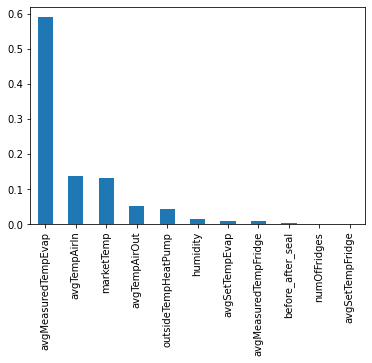

In [76]:
forest_model = RandomForestRegressor(random_state=0, n_estimators=130, max_features=0.6)
forest_model.fit(strong_pump_norm[X_vars[:11]].values, strong_pump_norm[y_var].values)

pd.Series(forest_model.feature_importances_, index=strong_pump_norm[X_vars[:11]].columns).sort_values(ascending=False).plot.bar()

### 94044.3.0: negative coef for seal, only one fridge<a name="pump2"></a>

Basic model

In [77]:
stats_model = sm.OLS(neg_coef[y_var], sm.add_constant(neg_coef[X_vars[:11]])).fit()
stats_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          chillingPower   R-squared:                       0.662
Model:                            OLS   Adj. R-squared:                  0.660
Method:                 Least Squares   F-statistic:                     286.6
Date:                Fri, 03 Feb 2023   Prob (F-statistic):          1.85e-302
Time:                        11:51:35   Log-Likelihood:                -1141.6
No. Observations:                1324   AIC:                             2303.
Df Residuals:                    1314   BIC:                             2355.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
before_after_seal        -0.0944      0.037     -2.560      0.011      -0.167      -0.022
numOfFridges              1.1142      0.234      4.752      0.000       0.654       1.574
avgMeasuredTempFridge     0.4309      0.128      3.353      0.001       0.179       0.683
avgSetTempFridge          1.1142      0.234      4.752      0.000       0.654       1.574
avgTempAirOut             0.2270      0.093      2.436      0.015       0.044       0.410
avgTempAirIn             -0.6188      0.074     -8.361      0.000      -0.764      -0.474
avgMeasuredTempEvap       0.6532      0.024     27.231      0.000       0.606       0.700
avgSetTempEvap           -0.3042      0.028    -10.905      0.000      -0.359      -0.249
outsideTempHeatPump       0.0161      0.008      2.087      0.037       0.001       0.031
marketTemp                0.1036      0.017      6.059      0.000       0.070       0.137
humidity                  0.0192      0.005      4.187      0.000       0.010       0.028
==============================================================================
Omnibus:                      125.369   Durbin-Watson:                   1.488
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              311.000
Skew:                           0.534   Prob(JB):                     2.93e-68
Kurtosis:                       5.120   Cond. No.                     1.08e+18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.6e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [78]:
stats_model = sm.OLS(neg_coef_norm[y_var], sm.add_constant(neg_coef_norm[X_vars[:11]])).fit()
stats_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          chillingPower   R-squared:                       0.662
Model:                            OLS   Adj. R-squared:                  0.660
Method:                 Least Squares   F-statistic:                     286.6
Date:                Fri, 03 Feb 2023   Prob (F-statistic):          1.85e-302
Time:                        11:51:35   Log-Likelihood:                -1159.7
No. Observations:                1324   AIC:                             2339.
Df Residuals:                    1314   BIC:                             2391.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.0486      0.025      1.956      0.051      -0.000       0.097
before_after_seal        -0.0957      0.037     -2.560      0.011      -0.169      -0.022
numOfFridges           2.182e-16   5.16e-17      4.232      0.000    1.17e-16    3.19e-16
avgMeasuredTempFridge     0.4355      0.130      3.353      0.001       0.181       0.690
avgSetTempFridge      -3.754e-16   3.13e-17    -12.005      0.000   -4.37e-16   -3.14e-16
avgTempAirOut             0.2079      0.085      2.436      0.015       0.040       0.375
avgTempAirIn             -0.7477      0.089     -8.361      0.000      -0.923      -0.572
avgMeasuredTempEvap       0.7617      0.028     27.231      0.000       0.707       0.817
avgSetTempEvap           -0.2511      0.023    -10.905      0.000      -0.296      -0.206
outsideTempHeatPump       0.0402      0.019      2.087      0.037       0.002       0.078
marketTemp                0.1476      0.024      6.059      0.000       0.100       0.195
humidity                  0.0980      0.023      4.187      0.000       0.052       0.144
==============================================================================
Omnibus:                      125.369   Durbin-Watson:                   1.488
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              311.000
Skew:                           0.534   Prob(JB):                     2.93e-68
Kurtosis:                       5.120   Cond. No.                     3.47e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.43e-32. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Cross validation on basic model

In [79]:
kfcv_results = pd.DataFrame(cross_validate(LinearRegression(), neg_coef[X_vars[:11]].values, neg_coef[y_var].values, 
                                           cv=ShuffleSplit(n_splits=10, random_state=0), scoring="r2", return_train_score=True))
kfcv_results

,fit_time,score_time,test_score,train_score
0,0.002,0.000,0.703,0.658
1,0.001,0.000,0.671,0.662
2,0.001,0.000,0.617,0.667
3,0.001,0.000,0.647,0.664
4,0.001,0.000,0.662,0.662
5,0.001,0.000,0.667,0.662
6,0.001,0.000,0.675,0.661
7,0.001,0.000,0.674,0.661
8,0.001,0.000,0.730,0.655
9,0.001,0.000,0.670,0.661


Depending on which variables are included in the model, the sign of the coefficient of the before_after_seal changes

In [80]:
# limited set of variables
stats_model = sm.OLS(neg_coef_norm[y_var], sm.add_constant(neg_coef_norm[["before_after_seal", "avgMeasuredTempFridge", "avgMeasuredTempEvap", "outsideTempHeatPump", "marketTemp", "humidity"]])).fit()
print("param:", np.round(stats_model.params["before_after_seal"], 5), "p-value:", np.round(stats_model.pvalues["before_after_seal"], 5), "rsquared:", np.round(stats_model.rsquared, 3))

param: -0.25516 p-value: 0.0 rsquared: 0.602


In [81]:
# fuller set of variables
stats_model = sm.OLS(neg_coef_norm[y_var], sm.add_constant(neg_coef_norm\
 [["before_after_seal", "numOfFridges", "avgSetTempFridge", "avgMeasuredTempFridge", "avgSetTempEvap", "avgMeasuredTempEvap", "outsideTempHeatPump", "marketTemp", "humidity"]])).fit()
print("param:", np.round(stats_model.params["before_after_seal"], 5), "p-value:", np.round(stats_model.pvalues["before_after_seal"], 5), "rsquared:", np.round(stats_model.rsquared, 3))

param: -0.14348 p-value: 0.00017 rsquared: 0.641


In [82]:
# full with temp air in
stats_model = sm.OLS(neg_coef_norm[y_var], sm.add_constant(neg_coef_norm\
 [["before_after_seal", "avgTempAirIn", "numOfFridges", "avgSetTempFridge", "avgMeasuredTempFridge", "avgSetTempEvap", "avgMeasuredTempEvap", "outsideTempHeatPump", "marketTemp", "humidity"]])).fit()
print("param:", np.round(stats_model.params["before_after_seal"], 5), "p-value:", np.round(stats_model.pvalues["before_after_seal"], 5), "rsquared:", np.round(stats_model.rsquared, 3))

param: -0.09679 p-value: 0.00985 rsquared: 0.661


In [83]:
# full with temp air out
stats_model = sm.OLS(neg_coef_norm[y_var], sm.add_constant(neg_coef_norm\
 [["before_after_seal", "avgTempAirOut", "numOfFridges", "avgSetTempFridge", "avgMeasuredTempFridge", "avgSetTempEvap", "avgMeasuredTempEvap", "outsideTempHeatPump", "marketTemp", "humidity"]])).fit()
print("param:", np.round(stats_model.params["before_after_seal"], 5), "p-value:", np.round(stats_model.pvalues["before_after_seal"], 5), "rsquared:", np.round(stats_model.rsquared, 3))


param: -0.13913 p-value: 0.00026 rsquared: 0.645


In [84]:
# full with both temp air in and out (as in above comparisons)
stats_model = sm.OLS(neg_coef_norm[y_var], sm.add_constant(neg_coef_norm\
 [["before_after_seal", "avgTempAirIn", "avgTempAirOut", "numOfFridges", "avgSetTempFridge", "avgMeasuredTempFridge", "avgSetTempEvap", "avgMeasuredTempEvap", "outsideTempHeatPump", "marketTemp", "humidity"]])).fit()
print("param:", np.round(stats_model.params["before_after_seal"], 5), "p-value:", np.round(stats_model.pvalues["before_after_seal"], 5), "rsquared:", np.round(stats_model.rsquared, 3))

param: -0.09569 p-value: 0.01058 rsquared: 0.662


With this heat pump, no matter what, the p value is always significant, and the coefficient is always negative.   
However the fit of the model is very poor.

Only at night

In [85]:
neg_coef_night = neg_coef.set_index("date").between_time("01:00", "04:00")
neg_coef_norm_night = neg_coef_norm.set_index("date").between_time("01:00", "04:00")

In [86]:
# limited set of variables
stats_model = sm.OLS(neg_coef_norm_night[y_var], sm.add_constant(neg_coef_norm_night[["before_after_seal", "avgMeasuredTempFridge", "avgMeasuredTempEvap", "outsideTempHeatPump", "marketTemp", "humidity"]])).fit()
print("param:", np.round(stats_model.params["before_after_seal"], 5), "p-value:", np.round(stats_model.pvalues["before_after_seal"], 5), "rsquared:", np.round(stats_model.rsquared, 3))

param: -0.14867 p-value: 0.00049 rsquared: 0.544


In [87]:
# fuller set of variables
stats_model = sm.OLS(neg_coef_norm_night[y_var], sm.add_constant(neg_coef_norm_night\
 [["before_after_seal", "numOfFridges", "avgSetTempFridge", "avgMeasuredTempFridge", "avgSetTempEvap", "avgMeasuredTempEvap", "outsideTempHeatPump", "marketTemp", "humidity"]])).fit()
print("param:", np.round(stats_model.params["before_after_seal"], 5), "p-value:", np.round(stats_model.pvalues["before_after_seal"], 5), "rsquared:", np.round(stats_model.rsquared, 3))

param: -0.12975 p-value: 0.00267 rsquared: 0.553


In [88]:
# full with temp air in
stats_model = sm.OLS(neg_coef_norm_night[y_var], sm.add_constant(neg_coef_norm_night\
 [["before_after_seal", "avgTempAirIn", "numOfFridges", "avgSetTempFridge", "avgMeasuredTempFridge", "avgSetTempEvap", "avgMeasuredTempEvap", "outsideTempHeatPump", "marketTemp", "humidity"]])).fit()
print("param:", np.round(stats_model.params["before_after_seal"], 5), "p-value:", np.round(stats_model.pvalues["before_after_seal"], 5), "rsquared:", np.round(stats_model.rsquared, 3))

param: -0.13592 p-value: 0.00266 rsquared: 0.554


In [89]:
# full with temp air out
stats_model = sm.OLS(neg_coef_norm_night[y_var], sm.add_constant(neg_coef_norm_night\
 [["before_after_seal", "avgTempAirOut", "numOfFridges", "avgSetTempFridge", "avgMeasuredTempFridge", "avgSetTempEvap", "avgMeasuredTempEvap", "outsideTempHeatPump", "marketTemp", "humidity"]])).fit()
print("param:", np.round(stats_model.params["before_after_seal"], 5), "p-value:", np.round(stats_model.pvalues["before_after_seal"], 5), "rsquared:", np.round(stats_model.rsquared, 3))

param: -0.12352 p-value: 0.0053 rsquared: 0.554


In [90]:
# full with both temp air in and out
stats_model = sm.OLS(neg_coef_norm_night[y_var], sm.add_constant(neg_coef_norm_night\
 [["before_after_seal", "avgTempAirIn", "avgTempAirOut", "numOfFridges", "avgSetTempFridge", "avgMeasuredTempFridge", "avgSetTempEvap", "avgMeasuredTempEvap", "outsideTempHeatPump", "marketTemp", "humidity"]])).fit()
print("param:", np.round(stats_model.params["before_after_seal"], 5), "p-value:", np.round(stats_model.pvalues["before_after_seal"], 5), "rsquared:", np.round(stats_model.rsquared, 3))

param: -0.12846 p-value: 0.00681 rsquared: 0.554


non linearity:

In [91]:
# hyperparameter parameter tuning with cross validation
random_forest = GridSearchCV(RandomForestRegressor(random_state=0), 
                             param_grid={'n_estimators':np.arange(100,200,10), 'max_features':np.round(np.arange(0.1,1.0,0.1),2)}, 
                             cv=ShuffleSplit(n_splits=10, random_state=0), scoring="r2",verbose=1,n_jobs=-1).fit(neg_coef_norm[X_vars[:11]], neg_coef_norm[y_var])

Fitting 10 folds for each of 90 candidates, totalling 900 fits


In [92]:
pd.DataFrame(random_forest.cv_results_).sort_values("rank_test_score").head(1)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,...,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
49,0.778,0.168,0.035,0.015,0.500,...,0.813,0.789,0.791,0.027,1


The mean test score is higher, suggesting non-linearity may be present in the model. However the effect of before/after seal is then extremely low.   
Furthermore, we don't know that this information is actually providing information about before/after seal, because it is correlated with time.

<AxesSubplot:>

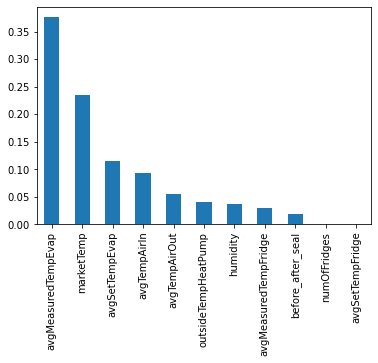

In [93]:
forest_model = RandomForestRegressor(random_state=0, n_estimators=190, max_features=0.5)
forest_model.fit(neg_coef_norm[X_vars[:11]].values, neg_coef_norm[y_var].values)

pd.Series(forest_model.feature_importances_, index=neg_coef_norm[X_vars[:11]].columns).sort_values(ascending=False).plot.bar()

### 89020.2.0: positive coef for seal, only one fridge<a name="pump3"></a>

Basic model

In [94]:
stats_model = sm.OLS(pos_coef[y_var], sm.add_constant(pos_coef[X_vars[:11]])).fit()
stats_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          chillingPower   R-squared:                       0.660
Model:                            OLS   Adj. R-squared:                  0.657
Method:                 Least Squares   F-statistic:                     287.2
Date:                Fri, 03 Feb 2023   Prob (F-statistic):          1.17e-304
Time:                        11:52:10   Log-Likelihood:                -1944.4
No. Observations:                1344   AIC:                             3909.
Df Residuals:                    1334   BIC:                             3961.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
before_after_seal         0.5158      0.080      6.449      0.000       0.359       0.673
numOfFridges             -3.9018      0.499     -7.822      0.000      -4.880      -2.923
avgMeasuredTempFridge     0.6092      0.237      2.572      0.010       0.145       1.074
avgSetTempFridge         -3.9018      0.499     -7.822      0.000      -4.880      -2.923
avgTempAirOut             0.0786      0.148      0.532      0.595      -0.212       0.369
avgTempAirIn             -0.6201      0.104     -5.978      0.000      -0.824      -0.417
avgMeasuredTempEvap       0.9952      0.048     20.579      0.000       0.900       1.090
avgSetTempEvap           -1.1340      0.048    -23.479      0.000      -1.229      -1.039
outsideTempHeatPump       0.0353      0.015      2.372      0.018       0.006       0.064
marketTemp                0.7025      0.056     12.598      0.000       0.593       0.812
humidity                  0.0180      0.012      1.510      0.131      -0.005       0.041
==============================================================================
Omnibus:                       60.583   Durbin-Watson:                   1.175
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               69.611
Skew:                           0.502   Prob(JB):                     7.66e-16
Kurtosis:                       3.484   Cond. No.                     4.36e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.01e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [95]:
stats_model = sm.OLS(pos_coef_norm[y_var], sm.add_constant(pos_coef_norm[X_vars[:11]])).fit()
stats_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          chillingPower   R-squared:                       0.660
Model:                            OLS   Adj. R-squared:                  0.657
Method:                 Least Squares   F-statistic:                     287.2
Date:                Fri, 03 Feb 2023   Prob (F-statistic):          1.17e-304
Time:                        11:52:10   Log-Likelihood:                -1183.0
No. Observations:                1344   AIC:                             2386.
Df Residuals:                    1334   BIC:                             2438.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.1464      0.028     -5.273      0.000      -0.201      -0.092
before_after_seal         0.2927      0.045      6.449      0.000       0.204       0.382
numOfFridges          -6.021e-16      2e-16     -3.014      0.003   -9.94e-16    -2.1e-16
avgMeasuredTempFridge     0.3221      0.125      2.572      0.010       0.076       0.568
avgSetTempFridge        7.09e-17   1.88e-17      3.778      0.000    3.41e-17    1.08e-16
avgTempAirOut             0.0419      0.079      0.532      0.595      -0.113       0.197
avgTempAirIn             -0.4237      0.071     -5.978      0.000      -0.563      -0.285
avgMeasuredTempEvap       0.5621      0.027     20.579      0.000       0.508       0.616
avgSetTempEvap           -0.7599      0.032    -23.479      0.000      -0.823      -0.696
outsideTempHeatPump       0.0590      0.025      2.372      0.018       0.010       0.108
marketTemp                0.2706      0.021     12.598      0.000       0.228       0.313
humidity                  0.0378      0.025      1.510      0.131      -0.011       0.087
==============================================================================
Omnibus:                       60.583   Durbin-Watson:                   1.175
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               69.611
Skew:                           0.502   Prob(JB):                     7.66e-16
Kurtosis:                       3.484   Cond. No.                     5.65e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.11e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [96]:
stats_model.params.abs().sort_values(ascending=False)

avgSetTempEvap          0.760
avgMeasuredTempEvap     0.562
avgTempAirIn            0.424
avgMeasuredTempFridge   0.322
before_after_seal       0.293
marketTemp              0.271
const                   0.146
outsideTempHeatPump     0.059
avgTempAirOut           0.042
humidity                0.038
numOfFridges            0.000
avgSetTempFridge        0.000
dtype: float64

Cross validation on basic model

In [97]:
kfcv_results = pd.DataFrame(cross_validate(LinearRegression(), pos_coef[X_vars[:11]].values, pos_coef[y_var].values, 
                                           cv=ShuffleSplit(n_splits=10, random_state=0), scoring="r2", return_train_score=True))
kfcv_results

,fit_time,score_time,test_score,train_score
0,0.002,0.000,0.675,0.658
1,0.001,0.000,0.560,0.669
2,0.001,0.000,0.659,0.659
3,0.001,0.000,0.664,0.657
4,0.001,0.000,0.598,0.666
5,0.001,0.000,0.639,0.661
6,0.001,0.000,0.644,0.661
7,0.001,0.000,0.712,0.654
8,0.001,0.000,0.574,0.669
9,0.001,0.000,0.643,0.661


Depending on which variables are included in the model, the sign of the coefficient of the before_after_seal changes

In [98]:
# limited set of variables
stats_model = sm.OLS(pos_coef_norm[y_var], sm.add_constant(pos_coef_norm[["before_after_seal", "avgMeasuredTempFridge", "avgMeasuredTempEvap", "outsideTempHeatPump", "marketTemp", "humidity"]])).fit()
print("param:", np.round(stats_model.params["before_after_seal"], 5), "p-value:", np.round(stats_model.pvalues["before_after_seal"], 5), "rsquared:", np.round(stats_model.rsquared, 3))

param: -0.00464 p-value: 0.91847 rsquared: 0.451


In [99]:
# fuller set of variables
stats_model = sm.OLS(pos_coef_norm[y_var], sm.add_constant(pos_coef_norm\
 [["before_after_seal", "numOfFridges", "avgSetTempFridge", "avgMeasuredTempFridge", "avgSetTempEvap", "avgMeasuredTempEvap", "outsideTempHeatPump", "marketTemp", "humidity"]])).fit()
print("param:", np.round(stats_model.params["before_after_seal"], 5), "p-value:", np.round(stats_model.pvalues["before_after_seal"], 5), "rsquared:", np.round(stats_model.rsquared, 3))

param: 0.02163 p-value: 0.55951 rsquared: 0.634


In [100]:
# full with temp air in
stats_model = sm.OLS(pos_coef_norm[y_var], sm.add_constant(pos_coef_norm\
 [["before_after_seal", "avgTempAirIn", "numOfFridges", "avgSetTempFridge", "avgMeasuredTempFridge", "avgSetTempEvap", "avgMeasuredTempEvap", "outsideTempHeatPump", "marketTemp", "humidity"]])).fit()
print("param:", np.round(stats_model.params["before_after_seal"], 5), "p-value:", np.round(stats_model.pvalues["before_after_seal"], 5), "rsquared:", np.round(stats_model.rsquared, 3))

param: 0.2879 p-value: 0.0 rsquared: 0.659


In [101]:
# full with temp air out
stats_model = sm.OLS(pos_coef_norm[y_var], sm.add_constant(pos_coef_norm\
 [["before_after_seal", "avgTempAirOut", "numOfFridges", "avgSetTempFridge", "avgMeasuredTempFridge", "avgSetTempEvap", "avgMeasuredTempEvap", "outsideTempHeatPump", "marketTemp", "humidity"]])).fit()
print("param:", np.round(stats_model.params["before_after_seal"], 5), "p-value:", np.round(stats_model.pvalues["before_after_seal"], 5), "rsquared:", np.round(stats_model.rsquared, 3))

param: 0.23418 p-value: 0.0 rsquared: 0.65


In [102]:
# full with both temp air in and out (as in above comparisons)
stats_model = sm.OLS(pos_coef_norm[y_var], sm.add_constant(pos_coef_norm\
 [["before_after_seal", "avgTempAirIn", "avgTempAirOut", "numOfFridges", "avgSetTempFridge", "avgMeasuredTempFridge", "avgSetTempEvap", "avgMeasuredTempEvap", "outsideTempHeatPump", "marketTemp", "humidity"]])).fit()
print("param:", np.round(stats_model.params["before_after_seal"], 5), "p-value:", np.round(stats_model.pvalues["before_after_seal"], 5), "rsquared:", np.round(stats_model.rsquared, 3))

param: 0.29273 p-value: 0.0 rsquared: 0.66


Only when temp air in or out is added, then is the p value for the door seal significant.

The strength of the differences in air in/out temperature has so much more of an effect on chilling power  
that if you don't control for this variable in the model, then before/after seal change can't tell us anything.

https://stats.stackexchange.com/a/80579

In [103]:
pos_coef.groupby("before_after_seal")[["avgTempAirIn", "avgTempAirOut", "numOfFridges", "avgSetTempFridge", "avgMeasuredTempFridge", "avgSetTempEvap", "avgMeasuredTempEvap", "outsideTempHeatPump", "marketTemp", "humidity"]].agg(["mean", "std"])

avgTempAirIn       avgTempAirOut       numOfFridges  ...  \
                          mean   std          mean   std         mean  ...   
before_after_seal                                                      ...   
0                       -0.403 1.288         2.451 1.001        1.000  ...   
1                        0.307 0.996         1.910 0.787        1.000  ...   

                  outsideTempHeatPump marketTemp       humidity        
                                  std       mean   std     mean   std  
before_after_seal                                                      
0                               3.361     15.090 0.665   50.388 4.377  
1                               2.463     15.003 0.691   48.793 2.675  

[2 rows x 20 columns]

In [104]:
pos_coef.groupby("before_after_seal")[["numOfFridges", "avgSetTempFridge", "avgMeasuredTempFridge", "avgSetTempEvap", "avgMeasuredTempEvap", "outsideTempHeatPump", "marketTemp", "humidity"]].agg(["mean", "std"])

numOfFridges       avgSetTempFridge        \
                          mean   std             mean   std   
before_after_seal                                             
0                        1.000 0.000            1.000 0.000   
1                        1.000 0.000            1.000 0.000   

                  avgMeasuredTempFridge  ... outsideTempHeatPump marketTemp  \
                                   mean  ...                 std       mean   
before_after_seal                        ...                                  
0                                 1.295  ...               3.361     15.090   
1                                 1.258  ...               2.463     15.003   

                        humidity        
                    std     mean   std  
before_after_seal                       
0                 0.665   50.388 4.377  
1                 0.691   48.793 2.675  

[2 rows x 16 columns]

Only at night

In [105]:
pos_coef_night = pos_coef.set_index("date").between_time("01:00", "04:00")
pos_coef_norm_night = pos_coef_norm.set_index("date").between_time("01:00", "04:00")

In [106]:
# limited set of variables
stats_model = sm.OLS(pos_coef_norm_night[y_var], sm.add_constant(pos_coef_norm_night[["before_after_seal", "avgMeasuredTempFridge", "avgMeasuredTempEvap", "outsideTempHeatPump", "marketTemp", "humidity"]])).fit()
print("param:", np.round(stats_model.params["before_after_seal"], 5), "p-value:", np.round(stats_model.pvalues["before_after_seal"], 5), "rsquared:", np.round(stats_model.rsquared, 3))

param: 0.06507 p-value: 0.09231 rsquared: 0.335


In [107]:
# fuller set of variables
stats_model = sm.OLS(pos_coef_norm_night[y_var], sm.add_constant(pos_coef_norm_night\
 [["before_after_seal", "numOfFridges", "avgSetTempFridge", "avgMeasuredTempFridge", "avgSetTempEvap", "avgMeasuredTempEvap", "outsideTempHeatPump", "marketTemp", "humidity"]])).fit()
print("param:", np.round(stats_model.params["before_after_seal"], 5), "p-value:", np.round(stats_model.pvalues["before_after_seal"], 5), "rsquared:", np.round(stats_model.rsquared, 3))

param: 0.05468 p-value: 0.15697 rsquared: 0.348


In [108]:
# full with temp air in
stats_model = sm.OLS(pos_coef_norm_night[y_var], sm.add_constant(pos_coef_norm_night\
 [["before_after_seal", "avgTempAirIn", "numOfFridges", "avgSetTempFridge", "avgMeasuredTempFridge", "avgSetTempEvap", "avgMeasuredTempEvap", "outsideTempHeatPump", "marketTemp", "humidity"]])).fit()
print("param:", np.round(stats_model.params["before_after_seal"], 5), "p-value:", np.round(stats_model.pvalues["before_after_seal"], 5), "rsquared:", np.round(stats_model.rsquared, 3))

param: 0.07226 p-value: 0.11516 rsquared: 0.35


In [109]:
# full with temp air out
stats_model = sm.OLS(pos_coef_norm_night[y_var], sm.add_constant(pos_coef_norm_night\
 [["before_after_seal", "avgTempAirOut", "numOfFridges", "avgSetTempFridge", "avgMeasuredTempFridge", "avgSetTempEvap", "avgMeasuredTempEvap", "outsideTempHeatPump", "marketTemp", "humidity"]])).fit()
print("param:", np.round(stats_model.params["before_after_seal"], 5), "p-value:", np.round(stats_model.pvalues["before_after_seal"], 5), "rsquared:", np.round(stats_model.rsquared, 3))

param: 0.07757 p-value: 0.09298 rsquared: 0.351


In [110]:
# full with both temp air in and out
stats_model = sm.OLS(pos_coef_norm_night[y_var], sm.add_constant(pos_coef_norm_night\
 [["before_after_seal", "avgTempAirIn", "avgTempAirOut", "numOfFridges", "avgSetTempFridge", "avgMeasuredTempFridge", "avgSetTempEvap", "avgMeasuredTempEvap", "outsideTempHeatPump", "marketTemp", "humidity"]])).fit()
print("param:", np.round(stats_model.params["before_after_seal"], 5), "p-value:", np.round(stats_model.pvalues["before_after_seal"], 5), "rsquared:", np.round(stats_model.rsquared, 3))

param: 0.07838 p-value: 0.09688 rsquared: 0.351


Before/after seal correlates with time.  
There are many different factors that can change over time: e.g. the contents of the fridge can be changed over time. Maybe one fridge gets used a lot, maybe another fridge does not, and this can be changed over time.  

This effect is therefore heightened when you look at only one heat pump, as you are removing more of the noise.

non linearity:

In [111]:
# hyperparameter parameter tuning with cross validation
random_forest = GridSearchCV(RandomForestRegressor(random_state=0), 
                             param_grid={'n_estimators':np.arange(100,200,10), 'max_features':np.round(np.arange(0.1,1.0,0.1),2)}, 
                             cv=ShuffleSplit(n_splits=10, random_state=0), scoring="r2",verbose=1,n_jobs=-1).fit(pos_coef_norm[X_vars[:11]], pos_coef_norm[y_var])

Fitting 10 folds for each of 90 candidates, totalling 900 fits


In [112]:
pd.DataFrame(random_forest.cv_results_).sort_values("rank_test_score").head(1)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,...,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
39,0.698,0.132,0.028,0.008,0.400,...,0.754,0.707,0.733,0.032,1


<AxesSubplot:>

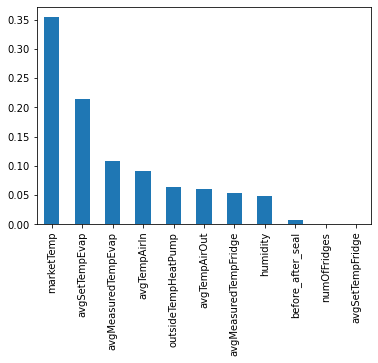

In [113]:
forest_model = RandomForestRegressor(random_state=0, n_estimators=190, max_features=0.4)
forest_model.fit(pos_coef_norm[X_vars[:11]].values, pos_coef_norm[y_var].values)

pd.Series(forest_model.feature_importances_, index=pos_coef_norm[X_vars[:11]].columns).sort_values(ascending=False).plot.bar()